In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.stats import chi2_contingency
from IPython.display import display, HTML
from scipy.stats import ks_2samp

In [2]:
os.makedirs("/home/onyxia/work/Federated_Learning_Milliman/images", exist_ok=True)

In [3]:
df_freMTPL = pd.read_csv("/home/onyxia/work/Federated_Learning_Milliman/data/french_data.csv")
df_beMTPL = pd.read_csv("/home/onyxia/work/Federated_Learning_Milliman/data/belgium_data.csv")
df_euMTPL = pd.read_csv("/home/onyxia/work/Federated_Learning_Milliman/data/european_data.csv")

In [4]:
print(len(df_freMTPL.index))
print(len(df_beMTPL.index))
print(len(df_euMTPL.index))

1089537
163212
2372377


In [5]:
# Étape 1 : Ajouter une colonne d'identification
df_freMTPL['Country'] = 'French'
df_beMTPL['Country'] = 'Belgium'
df_euMTPL['Country'] = 'European'

In [6]:
data = pd.concat([df_freMTPL, df_euMTPL, df_beMTPL], ignore_index=True)
data

,Exposure,Power,DriverAge,Fuel_type,Density,Sinistre,Sex,Country
0,0.09,0.336207,0.341463,1,0.002778,0,0,French
1,0.10,0.008621,0.451220,0,0.045039,1,0,French
2,0.84,0.336207,0.341463,1,0.002778,0,0,French
3,0.52,0.310345,0.243902,0,0.111189,0,0,French
4,0.77,0.008621,0.451220,0,0.045039,1,1,French
...,...,...,...,...,...,...,...,...
3625121,1.00,0.128755,0.246753,1,0.009890,0,1,Belgium
3625122,1.00,0.193133,0.337662,1,0.009890,0,1,Belgium
3625123,1.00,0.128755,0.415584,1,0.009890,0,1,Belgium
3625124,1.00,0.240343,0.324675,0,0.009890,0,1,Belgium


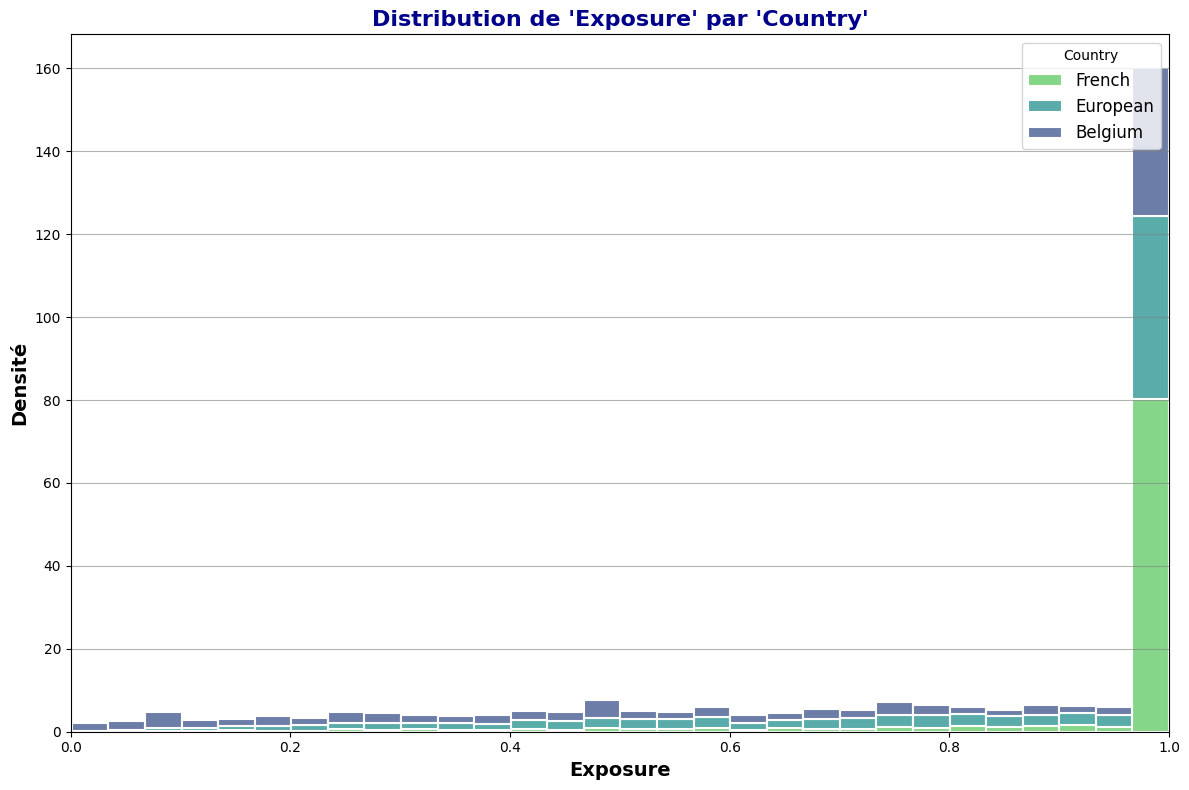

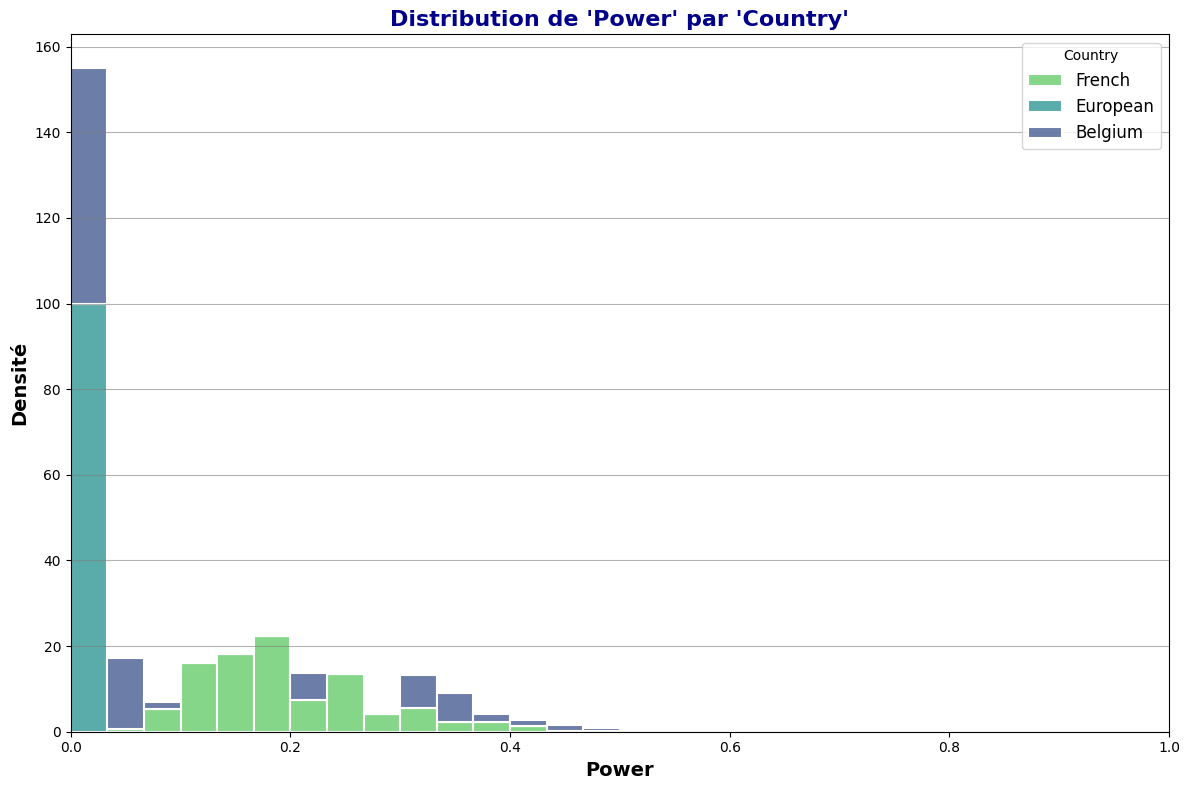

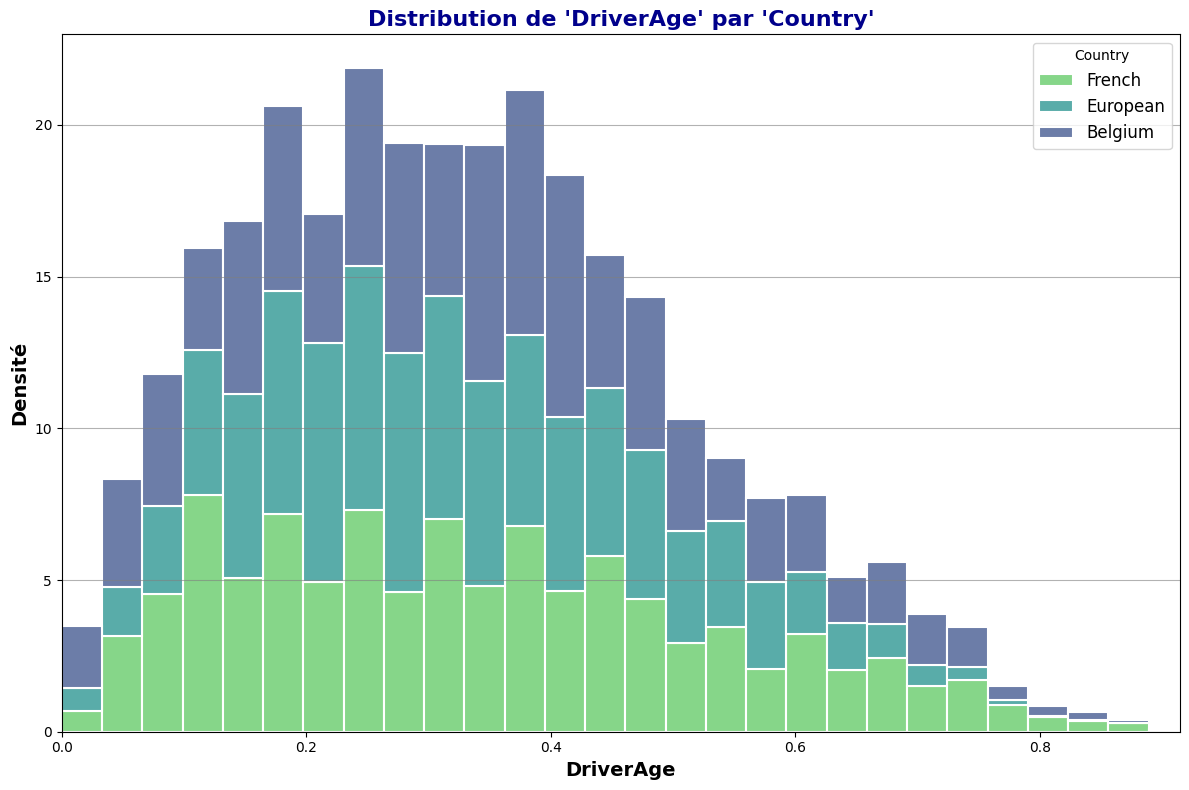

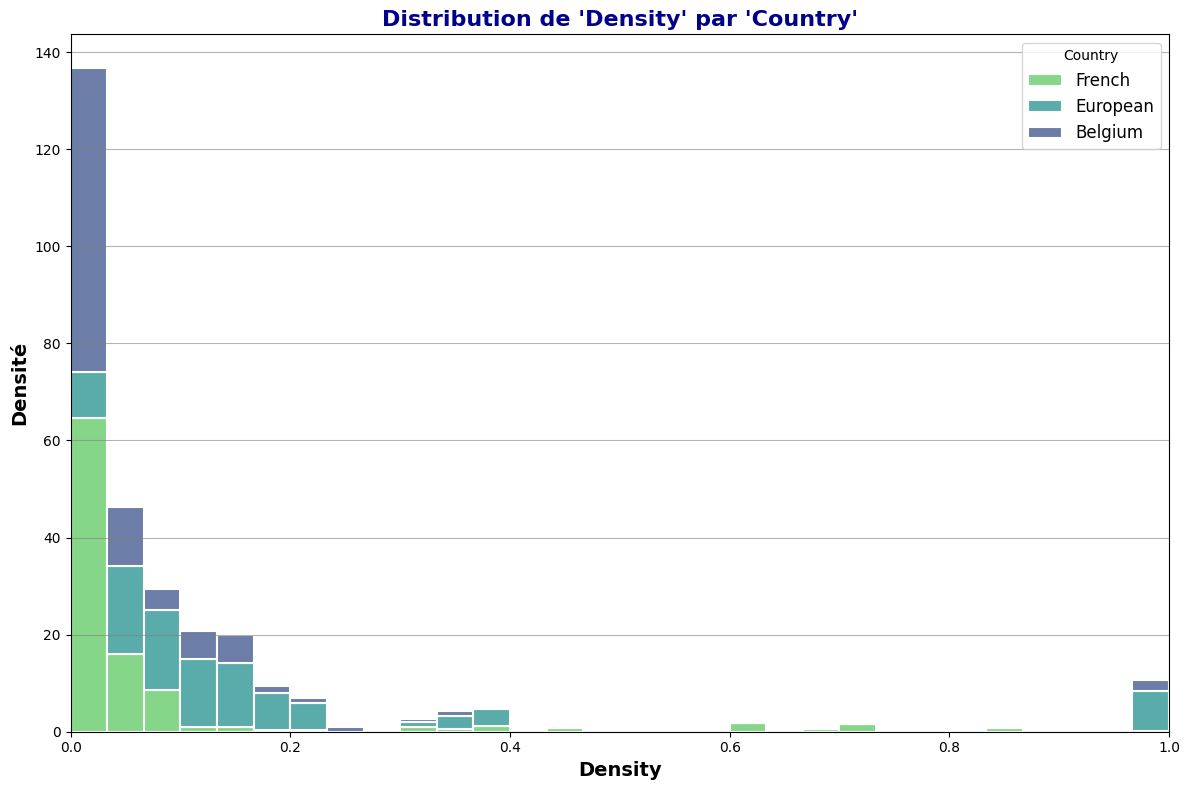

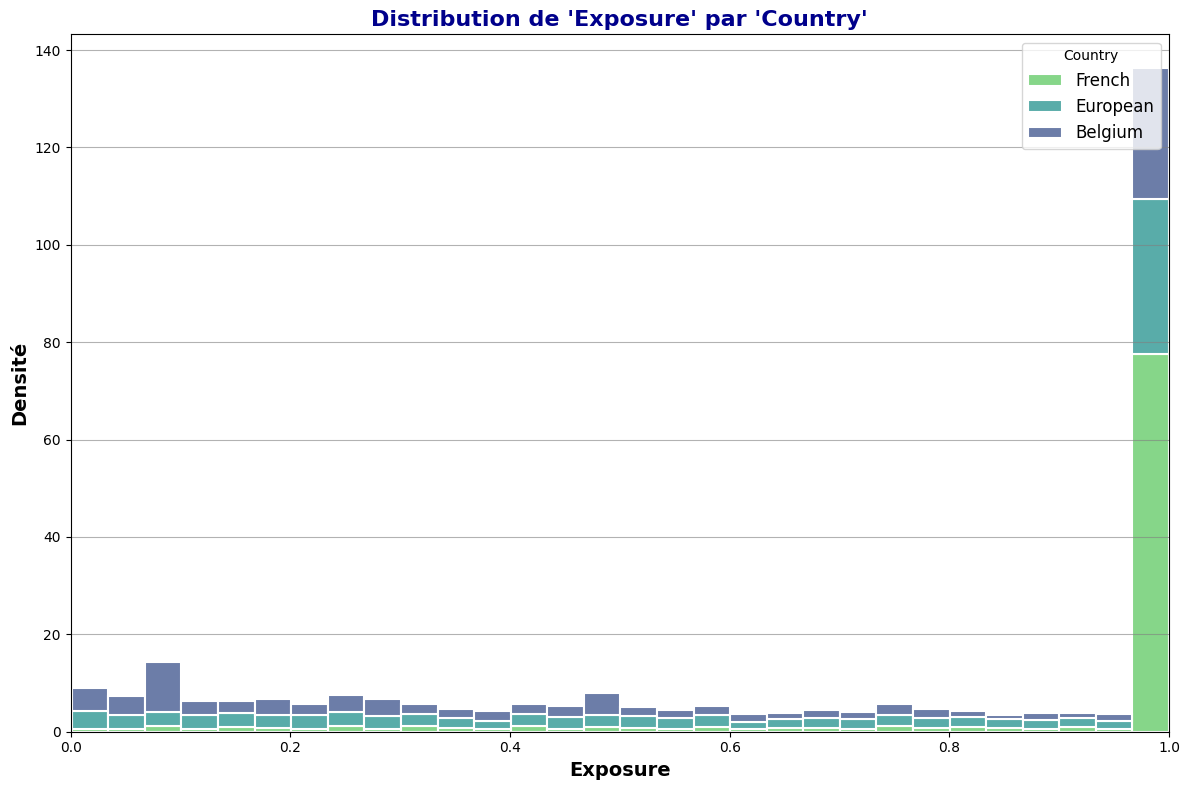

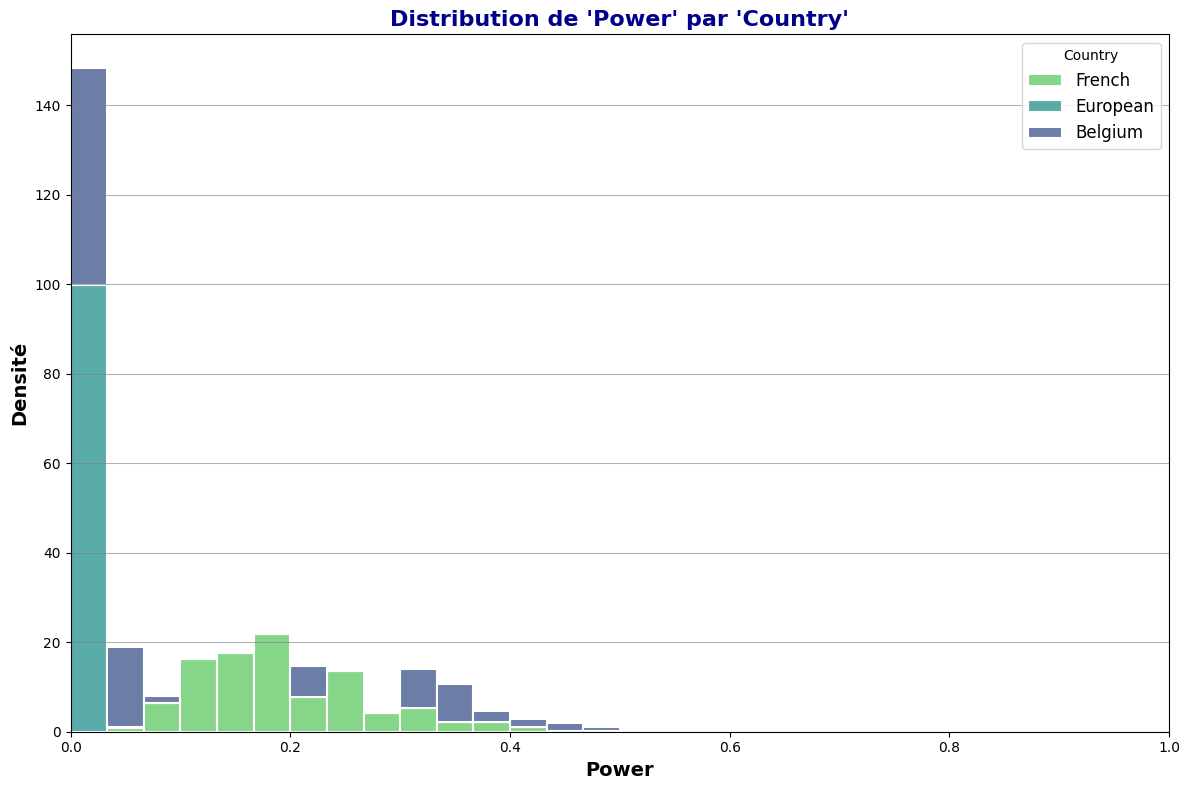

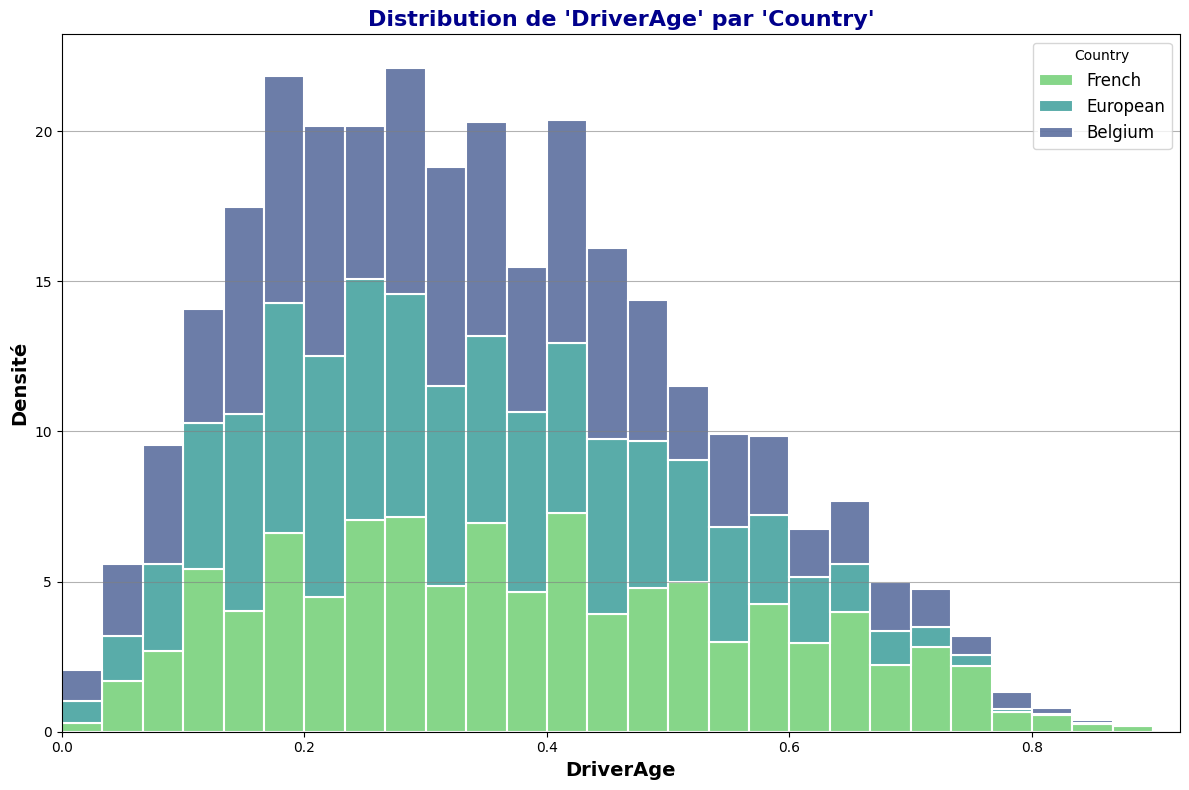

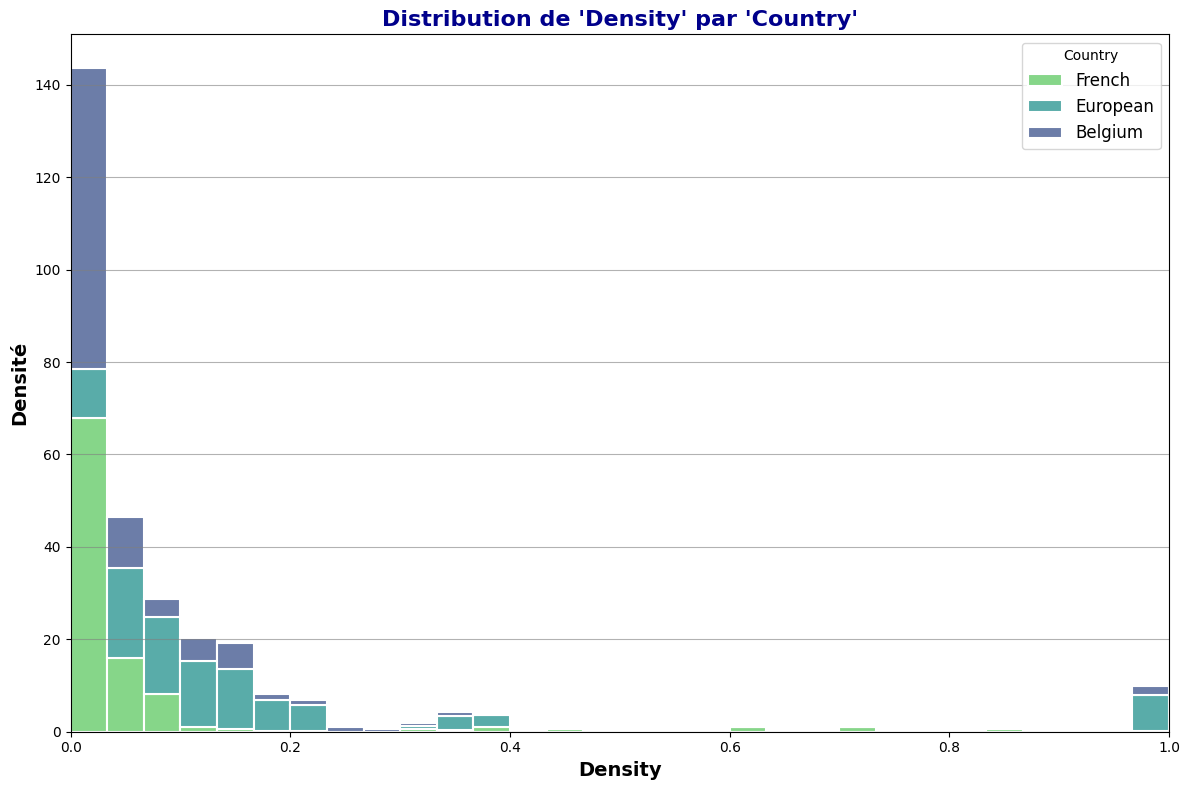

In [7]:
def plot_histograms_zoomed(df, colonne = '',group_col='Country', threshold_quantile=0.9999, bins=30):
    # Colonnes interdites d'être plottées
    excluded_columns = ['Sex', 'Fuel_type', 'Sinistre', group_col]
    
    # Sélectionner les colonnes numériques uniquement
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

    # Retirer les colonnes à exclure (même si elles sont numériques par accident)
    numeric_cols = [col for col in numeric_cols if col not in excluded_columns]

    for variable in numeric_cols:
        # Nettoyage : retirer les NaN pour la variable + group_col
        temp_df = df[[variable, group_col]].dropna()

        # Calcul automatique de la limite de zoom
        max_x = temp_df[variable].quantile(threshold_quantile)
        # Création du graphique
        plt.figure(figsize=(12, 8))
        sns.histplot(
            data=temp_df,
            x=variable,
            hue=group_col,
            multiple='stack',     
            stat='percent',       
            common_norm=False,    
            bins=bins,
            palette='viridis',    
            edgecolor='white',    
            linewidth=1.5
        )
        
        # Ajouter des éléments esthétiques
        plt.title(f"Distribution de '{variable}' par '{group_col}'", fontsize=16, fontweight='bold', color='darkblue')
        plt.xlabel(variable, fontsize=14, fontweight='bold')
        plt.ylabel('Densité', fontsize=14, fontweight='bold')
        plt.xlim(0, max_x)
        plt.grid(axis='y', linestyle='-', alpha=0.6, color='grey')

        # Ajouter une légende des pays
        plt.legend(title=group_col, loc='upper right', fontsize=12, labels=temp_df[group_col].unique())

        plt.tight_layout()
        plt.savefig(f"images/histogram_all_{variable}_{colonne}.png")
        plt.show()

data_sin = data[data['Sinistre'] == 1]
data_nsin = data[data['Sinistre'] == 0]

plot_histograms_zoomed(data_sin, colonne='Sinistre') 
plot_histograms_zoomed(data_nsin, colonne='Non_Sinistre')   

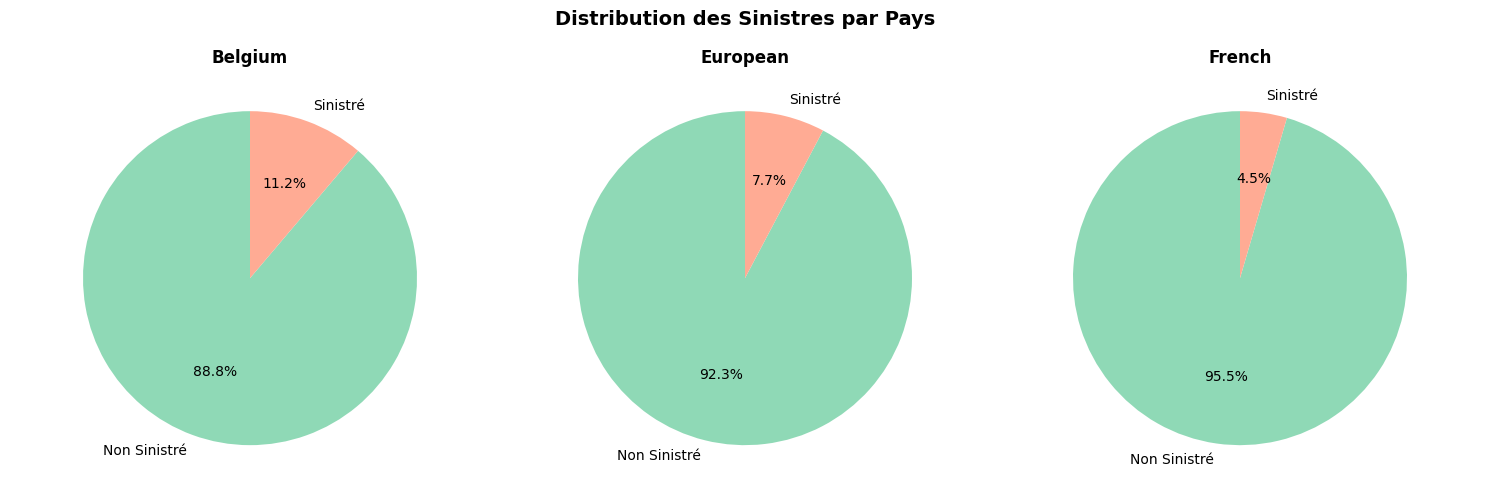

In [8]:
df_prop = data.groupby('Country')['Sinistre'].value_counts(normalize=True).unstack().fillna(0)
df_prop.columns = ['Non Sinistré', 'Sinistré']  # Renommage des colonnes pour clarté

# Création de la figure avec 3 pie charts
fig, axes = plt.subplots(1, len(df_prop), figsize=(15, 5))

colors = ['#8fd9b6', '#ffab94']

for i, (country, row) in enumerate(df_prop.iterrows()):
    ax = axes[i]
    ax.pie(row, labels=row.index, autopct='%1.1f%%', startangle=90, colors=colors)
    ax.set_title(f"{country}", fontsize=12, weight='bold')
    ax.axis('equal')  # Pour que le pie chart soit un cercle

fig.suptitle("Distribution des Sinistres par Pays", fontsize=14, weight='bold')
plt.tight_layout()
plt.savefig(f"images/piechart_Sinistre.png")
plt.show()

# Distribution de chaque variable

In [9]:
def afficher_repartition_sinistres(data, name, colonne="Sinistre", palette=["cyan", "red"], figsize=(6, 4)):
    class_distribution = data[colonne].value_counts(normalize=True) * 100

    plt.figure(figsize=figsize)
    sns.barplot(x=class_distribution.index, y=class_distribution.values, palette=palette)
    plt.xlabel(f"Classe {colonne} (0 = Pas de sinistre, 1 = Sinistre)")
    plt.ylabel("Proportion (%)")
    plt.title("Répartition des sinistres dans le dataset")
    plt.xticks([0, 1], ["Pas de sinistre", "Sinistre"])
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.savefig(f"images/distribution_{colonne}_{name}.png")
    plt.show()


In [10]:
# Style plus joli pour les plots
sns.set(style='whitegrid')


In [11]:
# Exemple de couleurs pour chaque variable
hist_colors = ['skyblue', 'lightgreen', 'salmon', 'plum']
kde_colors = ['blue', 'green', 'red', 'purple']

numerical_vars = ['Exposure', 'Power', 'DriverAge', 'Density']

# for i, var in enumerate(numerical_vars):
#     plt.figure(figsize=(8, 4))
    
#     # Histogramme sans la courbe KDE
#     sns.histplot(data[var], bins=30, color=hist_colors[i], stat="density", edgecolor="black", kde=False)
    
#     # Ajout de la courbe KDE avec une couleur différente
#     sns.kdeplot(data[var], color=kde_colors[i], linewidth=2)
    
#     plt.title(f'Distribution de {var}')
#     plt.xlabel(var)
#     plt.ylabel("Densité")
#     plt.tight_layout()
#     plt.show()


In [12]:
categorical_vars = ['Fuel_type', 'Sex', 'Country']

# Quelques palettes différentes de Seaborn
palettes = ['Set2', 'pastel', 'husl', 'muted']

# for i, var in enumerate(categorical_vars):
#     plt.figure(figsize=(6, 4))
#     sns.countplot(x=var, data=data, palette=palettes[i])
#     plt.title(f'Répartition de {var}')
#     plt.xlabel(var)
#     plt.ylabel("Nombre")
#     plt.tight_layout()
#     plt.show()


In [13]:
def analyse_variable_numerique(df, var_num, name, cible='Sinistre'):
    print(f"## Analyse de la variable numérique : {var_num}\n")
    
    # Statistiques descriptives
    display(df[[var_num]].describe())

    # Boxplot par classe
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')
    plt.title(f'{var_num} selon {cible}')
    plt.grid(True)
    plt.savefig(f"images/boxplot_{var_num}_{name}.png")
    plt.show()

    # Distribution KDE
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data=df, x=var_num, hue=cible, common_norm=False, fill=True)
    plt.title(f'Distribution de {var_num} selon {cible}')
    plt.savefig(f"images/distribution_{var_num}_{name}.png")
    plt.grid(True)
    plt.show()

        # Test de Kolmogorov-Smirnov
    groupe_0 = df[df[cible] == 0][var_num].dropna()
    groupe_1 = df[df[cible] == 1][var_num].dropna()
    ks_stat, p_value = ks_2samp(groupe_0, groupe_1)

    print("\n" + "="*60)
    print(f"🧪 Test de Kolmogorov-Smirnov sur la variable '{var_num}'")
    print("-" * 60)
    print(f"📈 Statistique KS : {ks_stat:.4f}")
    print(f"📊 Valeur p       : {p_value:.4e}")

    # Interprétation statistique
    if p_value < 0.05:
        print("✅ Résultat : Les distributions sont **significativement différentes** (p < 0.05)")
    else:
        print("❌ Résultat : Aucune différence significative détectée (p ≥ 0.05)")

    # Interprétation de l'intensité de la différence
    if ks_stat < 0.1:
        intensite = "⚪️ Très faible différence"
    elif ks_stat < 0.2:
        intensite = "🟢 Faible différence"
    elif ks_stat < 0.3:
        intensite = "🟠 Différence modérée"
    else:
        intensite = "🔴 Forte différence"

    print(f"📌 Intensité de l'écart : {intensite}")

    # Différence de médiane
    med_0 = groupe_0.median()
    med_1 = groupe_1.median()
    diff_medianes = abs(med_0 - med_1)

    print("-" * 60)
    print(f"📉 Médiane (classe 0) : {med_0:.2f}")
    print(f"📈 Médiane (classe 1) : {med_1:.2f}")
    print(f"➡️  Différence absolue de médiane : {diff_medianes:.2f}")
    print("="*60 + "\n")



In [14]:
def analyse_variable_categorielle(df, var_cat, name, cible='Sinistre'):
    print(f"## Analyse de la variable catégorielle : {var_cat}\n")
    
    # Calcul du taux de sinistre + nombre d'observations + sinistres
    stats = df.groupby(var_cat).agg(
        Effectif=(cible, 'count'),
        Nombre_sinistres=(cible, 'sum'),
        Taux_de_sinistre=(cible, 'mean')
    ).sort_values(by='Taux_de_sinistre', ascending=False).reset_index()

    # Affichage stylisé
    display(stats.style
            .format({'Taux_de_sinistre': '{:.2%}'})
            .background_gradient(cmap='Reds', subset=['Taux_de_sinistre'])
            .set_caption(f"Taux de sinistre par '{var_cat}'"))

    # Diagramme en barres verticales
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(data=df, x=var_cat, hue=cible, palette='Set2')
    plt.title(f'Distribution de {var_cat} selon {cible}')
    plt.xticks(rotation=90)  # Modalités affichées verticalement
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig(f"images/diagramme_{var_cat}_{name}.png")
    plt.show()


# Corrélation 

In [15]:
def afficher_correlation(data, variables, name, figsize=(7, 5), cmap="coolwarm"):
    corr_matrix = data[variables].corr()

    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, annot=True, cmap=cmap, fmt=".2f")
    plt.title("Corrélations entre variables numériques")
    plt.tight_layout()
    plt.savefig(f"images/corrplot_{name}.png")
    plt.show()


In [16]:
def analyze_categorical_correlation(data, cat_vars=['Fuel_type','Sinistre', 'Sex'], 
                                   alpha=0.05, figsize=(10, 8)):
   
    # Préparation des données
    cat_df = data[cat_vars].copy()
    for col in cat_df.select_dtypes(include='bool'):
        cat_df[col] = cat_df[col].astype(str)
    
    # Calcul des résultats
    results = []
    for i, var1 in enumerate(cat_vars[:-1]):
        for var2 in cat_vars[i+1:]:
            contingency_table = pd.crosstab(cat_df[var1], cat_df[var2])
            chi2, p, dof, _ = chi2_contingency(contingency_table)
            
            # Calcul du Cramer's V
            n = contingency_table.sum().sum()
            cramer_v = np.sqrt(chi2 / (n * min(contingency_table.shape[0]-1, contingency_table.shape[1]-1)))
            
            # Interprétation
            strength = "Très forte" if cramer_v >= 0.5 else \
                     "Forte" if cramer_v >= 0.3 else \
                     "Modérée" if cramer_v >= 0.1 else "Faible"
            
            results.append({
                'Paire de variables': f"{var1} - {var2}",
                'Cramer\'s V': cramer_v,
                'Force de la corrélation': strength,
                'p-value': p,
                'Significatif': p < alpha
            })
    
    # Création du DataFrame de résultats
    results_df = pd.DataFrame(results)
    
    # Style pour la visualisation
    def color_strength(val):
        color = 'white'
        if val == "Très forte": color = '#FF0000'  # Rouge
        elif val == "Forte": color = '#FF6666'     # Rouge clair
        elif val == "Modérée": color = '#FFCCCC'   # Rouge très clair
        return f'background-color: {color}'
    
    def color_pvalue(val):
        color = 'limegreen' if val < alpha else 'lightcoral'
        return f'color: {color}; font-weight: bold'
    
    # Application du style
    styled_df = results_df.style \
        .applymap(color_pvalue, subset=['p-value']) \
        .applymap(lambda x: 'background-color: limegreen' if x else 'background-color: lightcoral', 
                 subset=['Significatif']) \
        .applymap(color_strength, subset=['Force de la corrélation']) \
        .format({
            'Cramer\'s V': "{:.3f}",
            'p-value': "{:.4f}"
        }) \
        .set_caption("Résultats des tests de corrélation entre variables catégorielles") \
        .set_properties(**{
            'text-align': 'center',
            'font-size': '12pt',
            'border': '1px solid black'
        })
    
    # Affichage dans Jupyter
    display(styled_df)
    return results_df


In [17]:
#STATS DE LA BASE CONCATÉNER 
# Liste des variables
vars_num = ['Exposure', 'Power', 'DriverAge', 'Density']
vars_cat = ['Fuel_type', 'Sex']


# afficher_repartition_sinistres(data)
# # Analyse automatique
# for var in vars_num:
#     analyse_variable_numerique(data, var)

# for var in vars_cat:
#     analyse_variable_categorielle(data, var)

# #Corrélation 
# afficher_correlation(data, vars_num)
# results = analyze_categorical_correlation(data)

# Base française 

/tmp/ipykernel_38726/797443313.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette=palette)


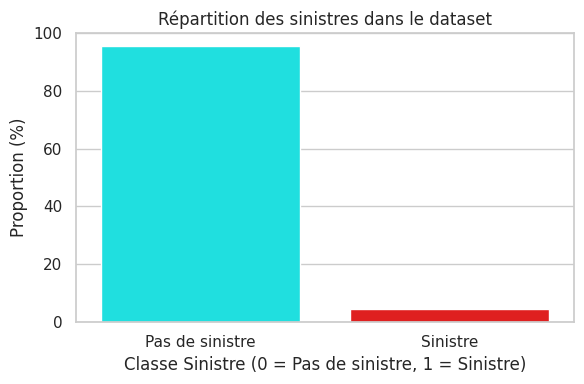

## Analyse de la variable numérique : Exposure



,Exposure
count,1.089537e+06
mean,5.401334e-01
std,3.662465e-01
min,2.732240e-03
25%,1.900000e-01
50%,5.000000e-01
75%,1.000000e+00
max,1.000000e+00


/tmp/ipykernel_38726/2819472562.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


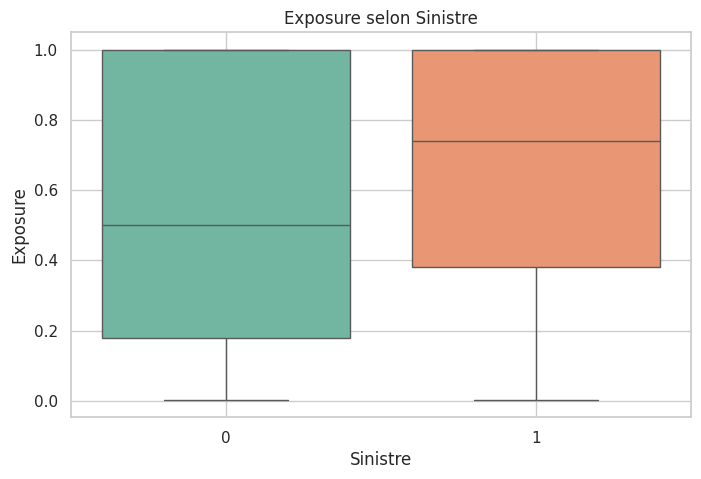

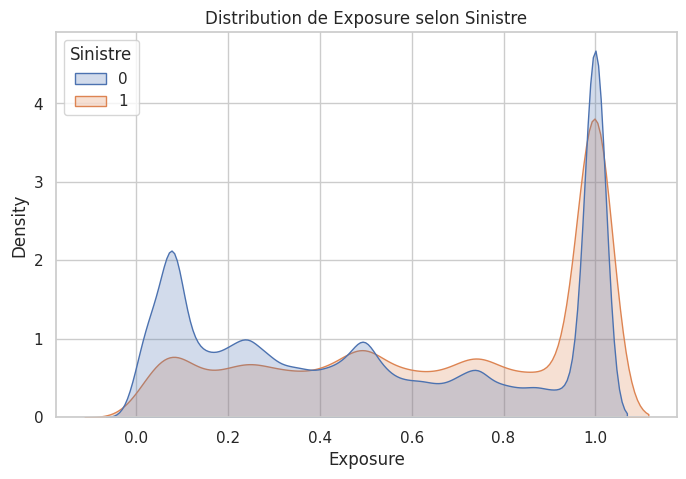


🧪 Test de Kolmogorov-Smirnov sur la variable 'Exposure'
------------------------------------------------------------
📈 Statistique KS : 0.1639
📊 Valeur p       : 0.0000e+00
✅ Résultat : Les distributions sont **significativement différentes** (p < 0.05)
📌 Intensité de l'écart : 🟢 Faible différence
------------------------------------------------------------
📉 Médiane (classe 0) : 0.50
📈 Médiane (classe 1) : 0.74
➡️  Différence absolue de médiane : 0.24

## Analyse de la variable numérique : Power



,Power
count,1.089537e+06
mean,1.214688e-01
std,1.535352e-01
min,0.000000e+00
25%,1.724138e-02
50%,3.448276e-02
75%,2.241379e-01
max,1.000000e+00


/tmp/ipykernel_38726/2819472562.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


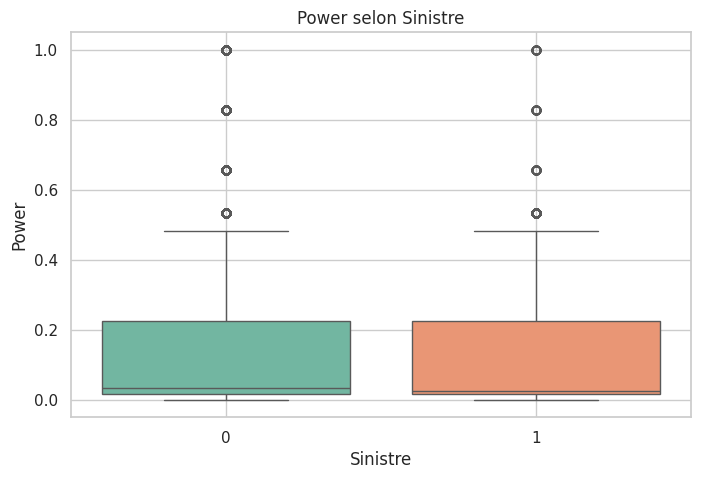

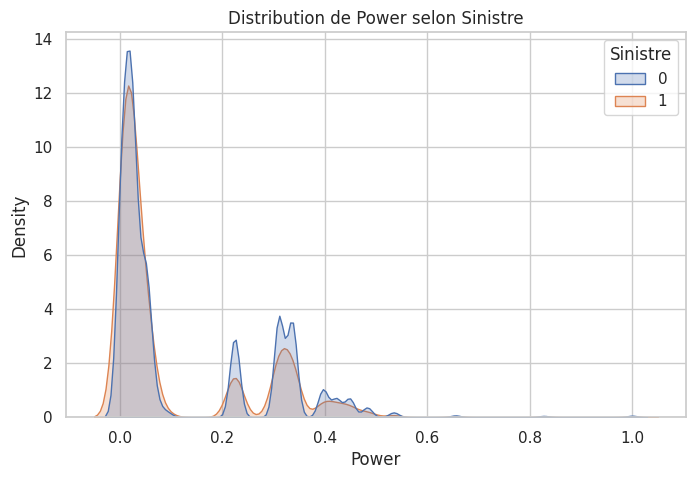


🧪 Test de Kolmogorov-Smirnov sur la variable 'Power'
------------------------------------------------------------
📈 Statistique KS : 0.0662
📊 Valeur p       : 8.3109e-180
✅ Résultat : Les distributions sont **significativement différentes** (p < 0.05)
📌 Intensité de l'écart : ⚪️ Très faible différence
------------------------------------------------------------
📉 Médiane (classe 0) : 0.03
📈 Médiane (classe 1) : 0.03
➡️  Différence absolue de médiane : 0.01

## Analyse de la variable numérique : DriverAge



,DriverAge
count,1.089537e+06
mean,3.345291e-01
std,1.733262e-01
min,0.000000e+00
25%,1.951220e-01
50%,3.170732e-01
75%,4.512195e-01
max,1.000000e+00


/tmp/ipykernel_38726/2819472562.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


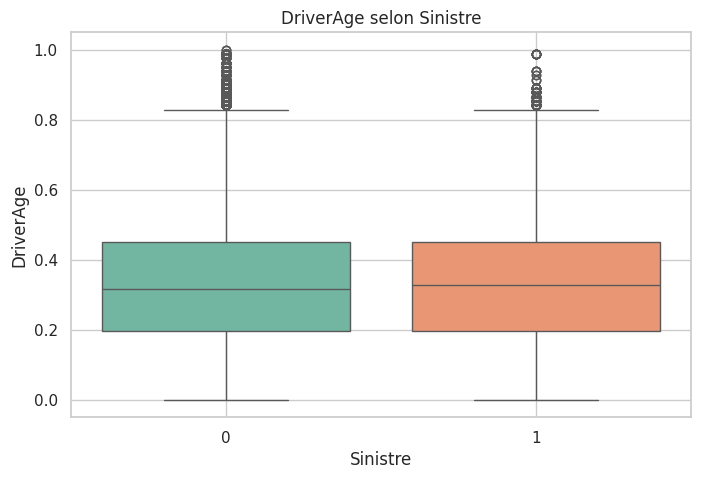

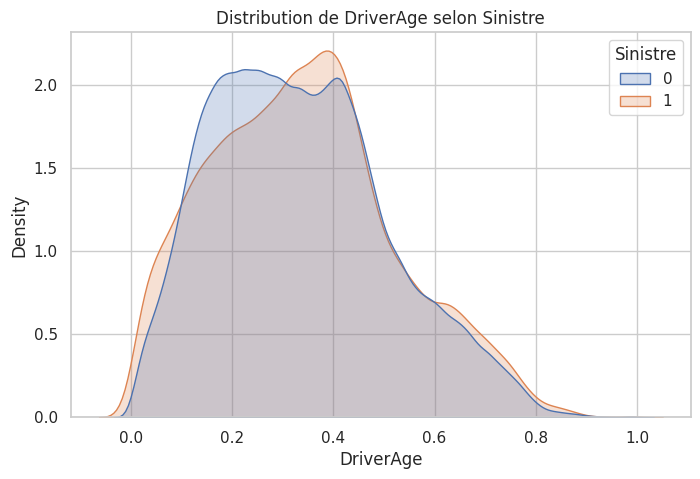


🧪 Test de Kolmogorov-Smirnov sur la variable 'DriverAge'
------------------------------------------------------------
📈 Statistique KS : 0.0299
📊 Valeur p       : 5.9975e-37
✅ Résultat : Les distributions sont **significativement différentes** (p < 0.05)
📌 Intensité de l'écart : ⚪️ Très faible différence
------------------------------------------------------------
📉 Médiane (classe 0) : 0.32
📈 Médiane (classe 1) : 0.33
➡️  Différence absolue de médiane : 0.01

## Analyse de la variable numérique : Density



,Density
count,1.089537e+06
mean,6.902472e-02
std,1.588051e-01
min,0.000000e+00
25%,3.037150e-03
50%,1.307456e-02
75%,5.763176e-02
max,1.000000e+00


/tmp/ipykernel_38726/2819472562.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


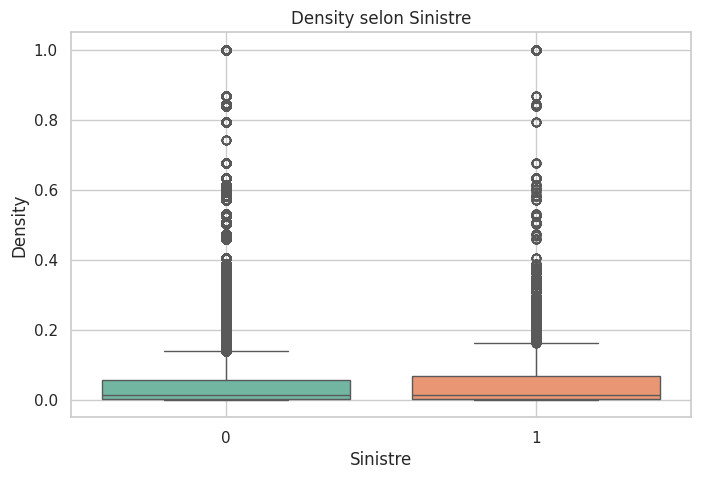

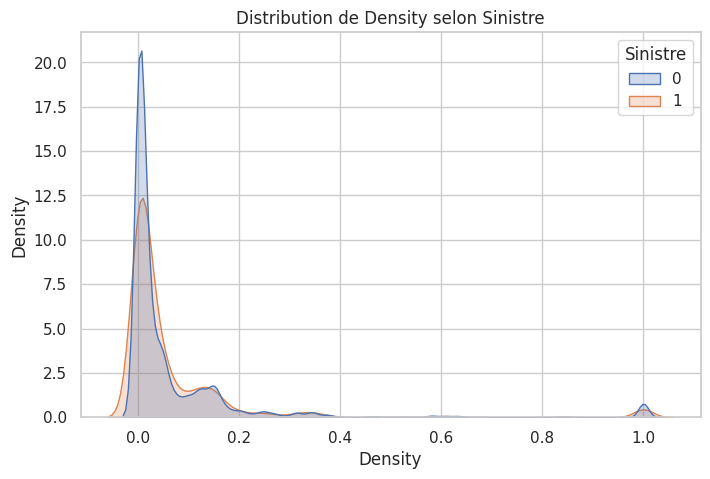


🧪 Test de Kolmogorov-Smirnov sur la variable 'Density'
------------------------------------------------------------
📈 Statistique KS : 0.0336
📊 Valeur p       : 1.0360e-46
✅ Résultat : Les distributions sont **significativement différentes** (p < 0.05)
📌 Intensité de l'écart : ⚪️ Très faible différence
------------------------------------------------------------
📉 Médiane (classe 0) : 0.01
📈 Médiane (classe 1) : 0.01
➡️  Différence absolue de médiane : 0.00

## Analyse de la variable catégorielle : Fuel_type



,Fuel_type,Effectif,Nombre_sinistres,Taux_de_sinistre
0,0,552270,25656,4.65%
1,1,537267,23727,4.42%


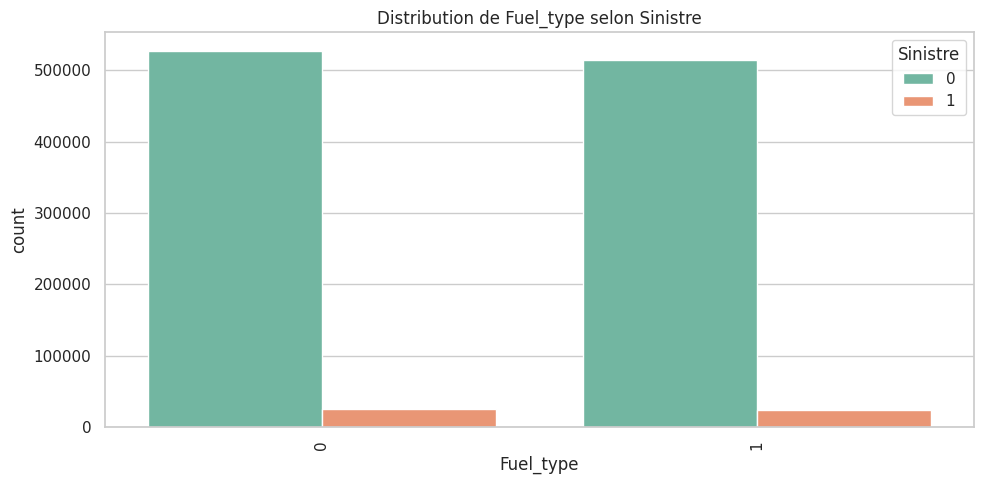

## Analyse de la variable catégorielle : Sex



,Sex,Effectif,Nombre_sinistres,Taux_de_sinistre
0,1,552516,32602,5.90%
1,0,537021,16781,3.12%


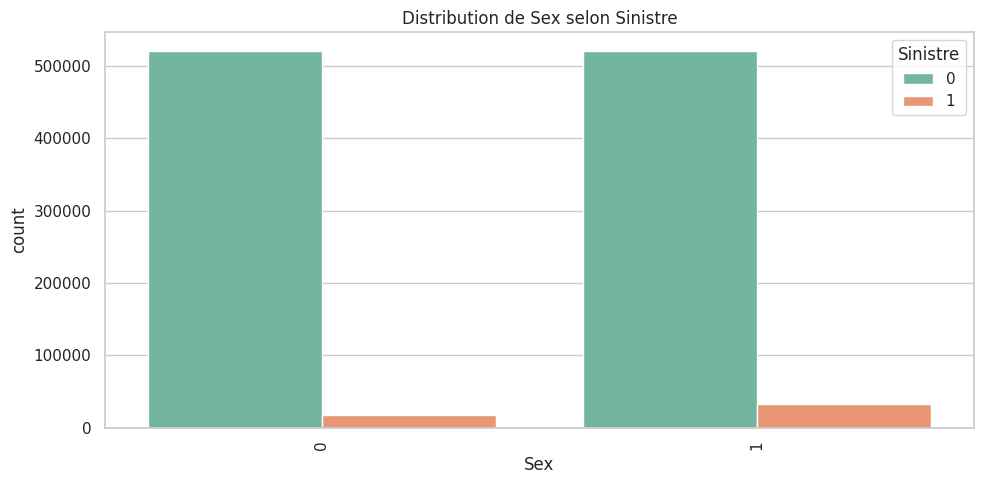

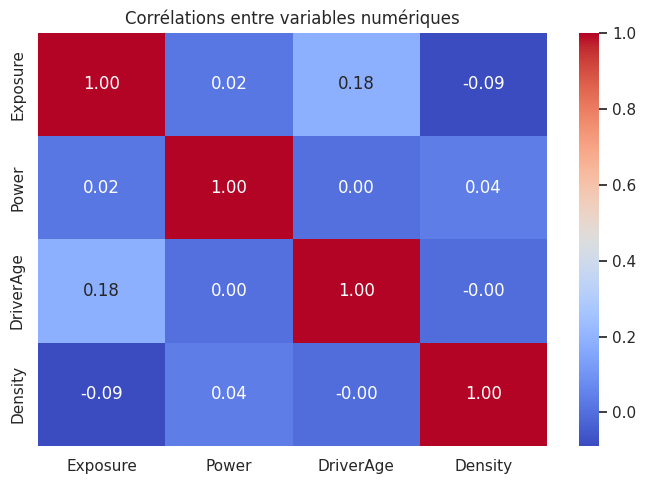

/tmp/ipykernel_38726/2745208832.py:50: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_pvalue, subset=['p-value']) \
/tmp/ipykernel_38726/2745208832.py:51: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'background-color: limegreen' if x else 'background-color: lightcoral',
/tmp/ipykernel_38726/2745208832.py:53: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_strength, subset=['Force de la corrélation']) \


,Paire de variables,Cramer's V,Force de la corrélation,p-value,Significatif
0,Fuel_type - Sinistre,0.006,Faible,0.0000,True
1,Fuel_type - Sex,0.001,Faible,0.4178,False
2,Sinistre - Sex,0.067,Faible,0.0000,True


In [18]:
# Liste des variables
vars_num = ['Exposure', 'Power', 'DriverAge', 'Density']
vars_cat = ['Fuel_type', 'Sex']


afficher_repartition_sinistres(df_freMTPL,'french')
# Analyse automatique
for var in vars_num:
    analyse_variable_numerique(df_freMTPL, var,'french')

for var in vars_cat:
    analyse_variable_categorielle(df_freMTPL, var,'french')

#Corrélation 
afficher_correlation(df_freMTPL, vars_num,'french')
results = analyze_categorical_correlation(df_freMTPL)

# Base européenne 

/tmp/ipykernel_38726/797443313.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette=palette)


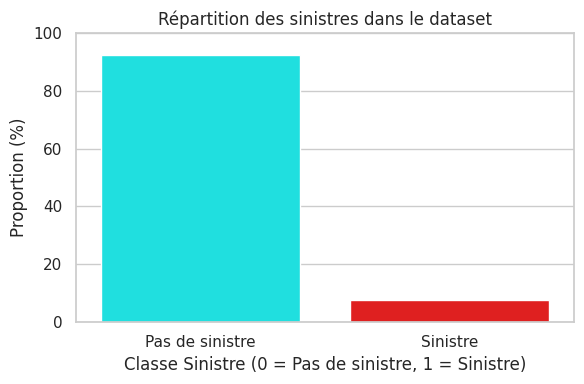

## Analyse de la variable numérique : Exposure



,Exposure
count,2.372377e+06
mean,6.265849e-01
std,3.473193e-01
min,1.000000e-03
25%,3.005464e-01
50%,6.821918e-01
75%,1.000000e+00
max,1.000000e+00


/tmp/ipykernel_38726/2819472562.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


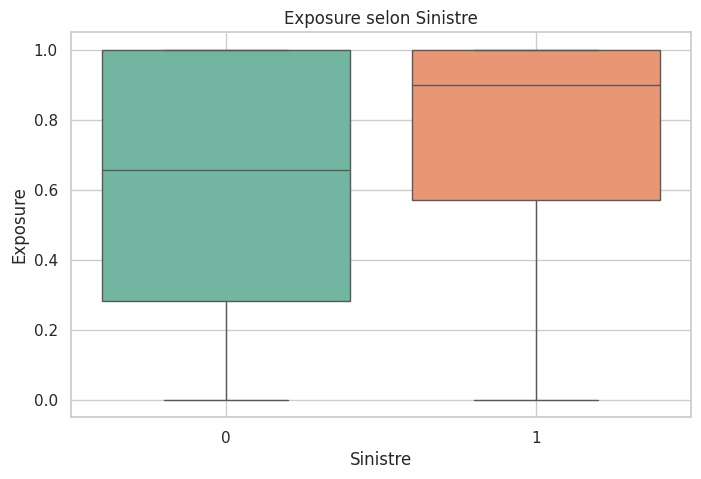

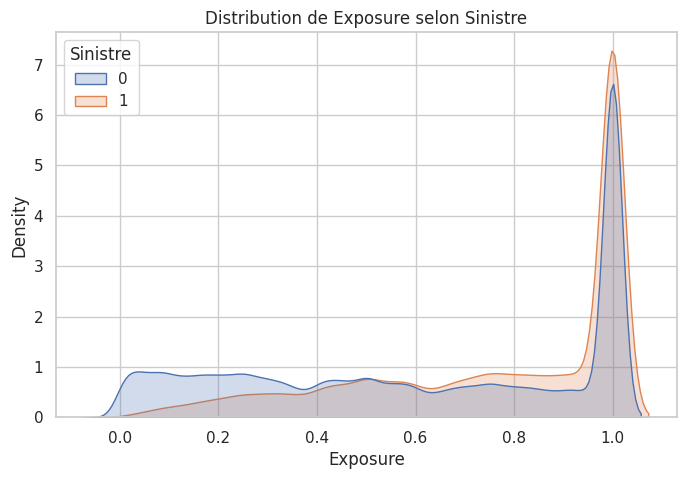


🧪 Test de Kolmogorov-Smirnov sur la variable 'Exposure'
------------------------------------------------------------
📈 Statistique KS : 0.2045
📊 Valeur p       : 0.0000e+00
✅ Résultat : Les distributions sont **significativement différentes** (p < 0.05)
📌 Intensité de l'écart : 🟠 Différence modérée
------------------------------------------------------------
📉 Médiane (classe 0) : 0.66
📈 Médiane (classe 1) : 0.90
➡️  Différence absolue de médiane : 0.24

## Analyse de la variable numérique : Power



,Power
count,2.372377e+06
mean,1.653661e-02
std,4.565388e-03
min,0.000000e+00
25%,1.401401e-02
50%,1.601602e-02
75%,1.901902e-02
max,1.000000e+00


/tmp/ipykernel_38726/2819472562.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


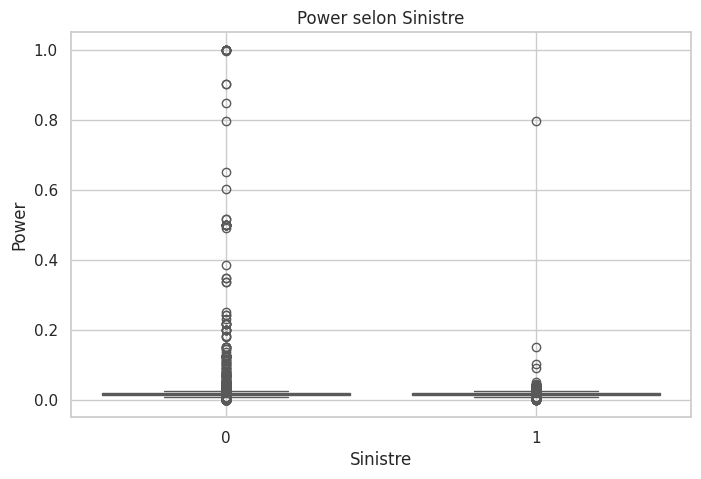

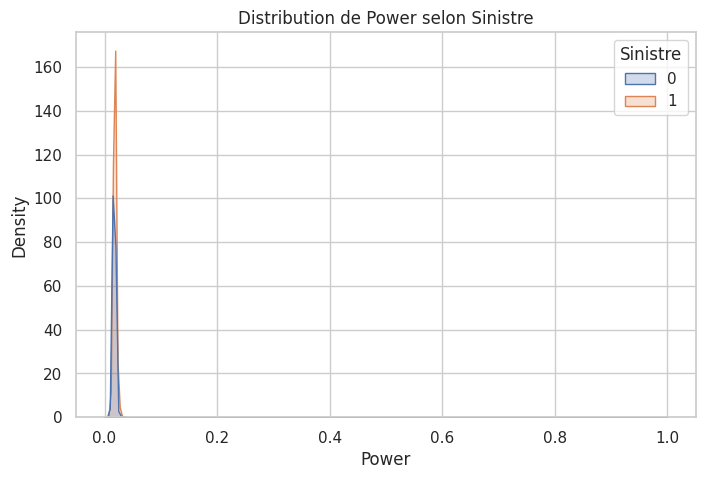


🧪 Test de Kolmogorov-Smirnov sur la variable 'Power'
------------------------------------------------------------
📈 Statistique KS : 0.0398
📊 Valeur p       : 6.4486e-234
✅ Résultat : Les distributions sont **significativement différentes** (p < 0.05)
📌 Intensité de l'écart : ⚪️ Très faible différence
------------------------------------------------------------
📉 Médiane (classe 0) : 0.02
📈 Médiane (classe 1) : 0.02
➡️  Différence absolue de médiane : 0.00

## Analyse de la variable numérique : DriverAge



,DriverAge
count,2.372377e+06
mean,3.315947e-01
std,1.594435e-01
min,0.000000e+00
25%,2.087912e-01
50%,3.076923e-01
75%,4.505495e-01
max,1.000000e+00


/tmp/ipykernel_38726/2819472562.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


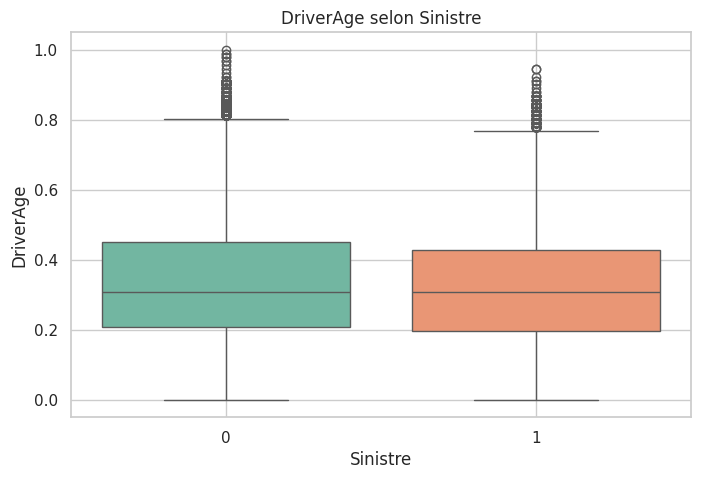

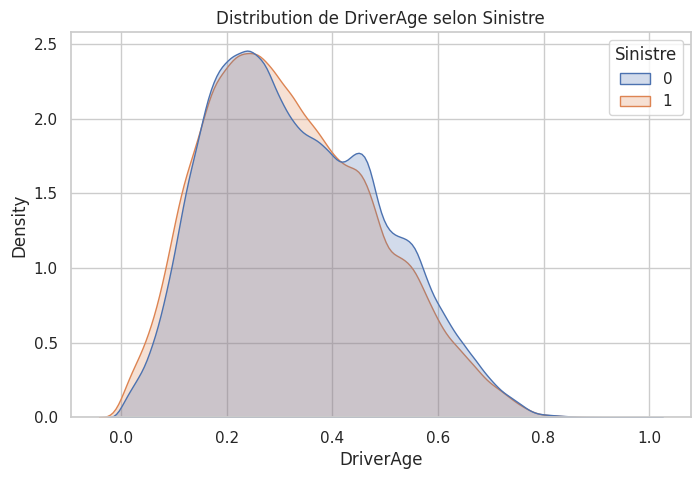


🧪 Test de Kolmogorov-Smirnov sur la variable 'DriverAge'
------------------------------------------------------------
📈 Statistique KS : 0.0301
📊 Valeur p       : 7.1239e-134
✅ Résultat : Les distributions sont **significativement différentes** (p < 0.05)
📌 Intensité de l'écart : ⚪️ Très faible différence
------------------------------------------------------------
📉 Médiane (classe 0) : 0.31
📈 Médiane (classe 1) : 0.31
➡️  Différence absolue de médiane : 0.00

## Analyse de la variable numérique : Density



,Density
count,2.372377e+06
mean,1.891237e-01
std,2.533956e-01
min,0.000000e+00
25%,5.589431e-02
50%,1.143293e-01
75%,1.869919e-01
max,1.000000e+00


/tmp/ipykernel_38726/2819472562.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


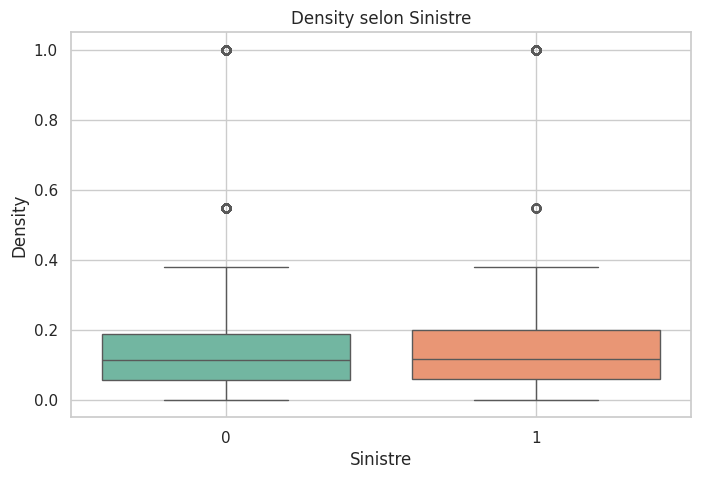

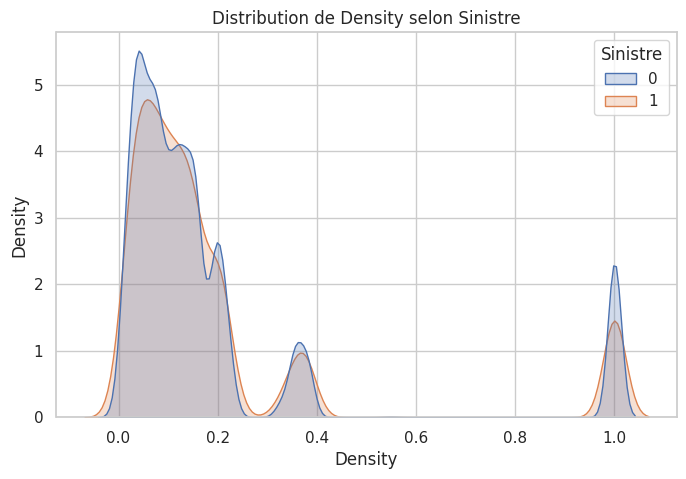


🧪 Test de Kolmogorov-Smirnov sur la variable 'Density'
------------------------------------------------------------
📈 Statistique KS : 0.0299
📊 Valeur p       : 4.8669e-132
✅ Résultat : Les distributions sont **significativement différentes** (p < 0.05)
📌 Intensité de l'écart : ⚪️ Très faible différence
------------------------------------------------------------
📉 Médiane (classe 0) : 0.11
📈 Médiane (classe 1) : 0.12
➡️  Différence absolue de médiane : 0.00

## Analyse de la variable catégorielle : Fuel_type



,Fuel_type,Effectif,Nombre_sinistres,Taux_de_sinistre
0,1,945235,83280,8.81%
1,0,1427142,100282,7.03%


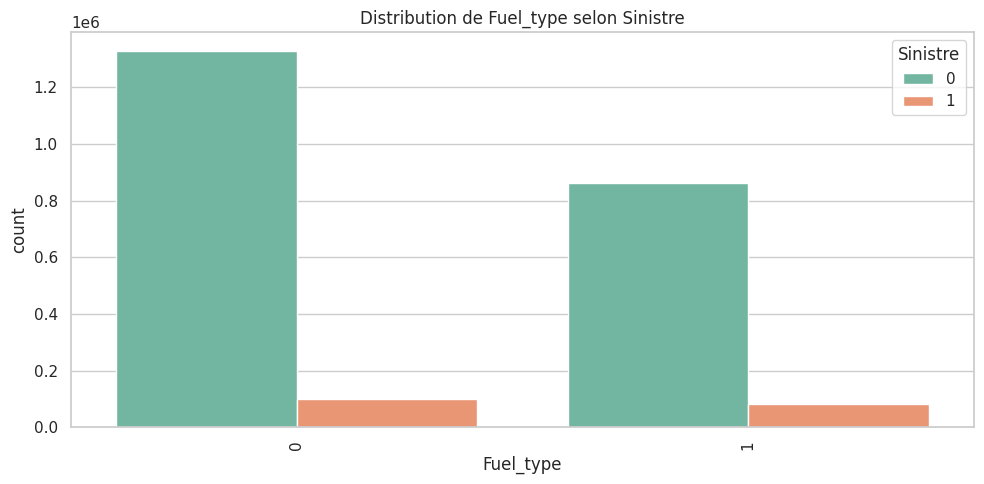

## Analyse de la variable catégorielle : Sex



,Sex,Effectif,Nombre_sinistres,Taux_de_sinistre
0,0,892986,70120,7.85%
1,1,1479391,113442,7.67%


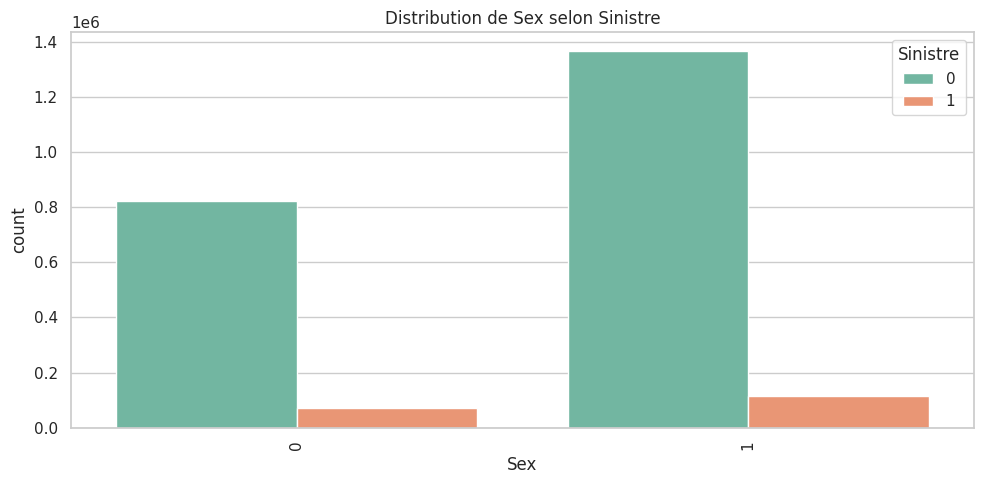

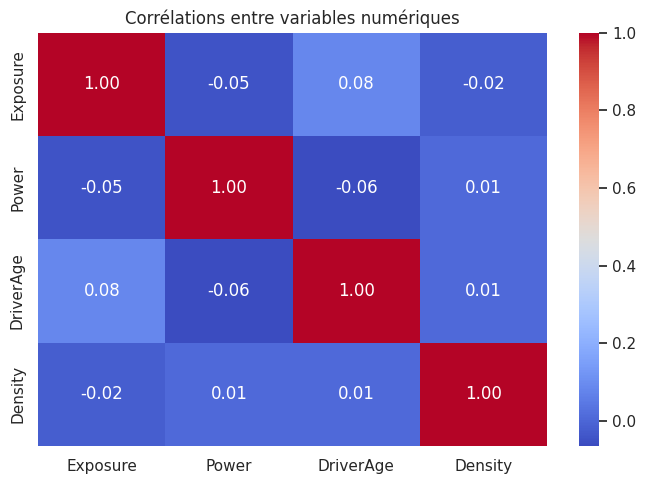

/tmp/ipykernel_38726/2745208832.py:50: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_pvalue, subset=['p-value']) \
/tmp/ipykernel_38726/2745208832.py:51: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'background-color: limegreen' if x else 'background-color: lightcoral',
/tmp/ipykernel_38726/2745208832.py:53: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_strength, subset=['Force de la corrélation']) \


,Paire de variables,Cramer's V,Force de la corrélation,p-value,Significatif
0,Fuel_type - Sinistre,0.033,Faible,0.0000,True
1,Fuel_type - Sex,0.153,Modérée,0.0000,True
2,Sinistre - Sex,0.003,Faible,0.0000,True


In [19]:
# Liste des variables
vars_num = ['Exposure', 'Power', 'DriverAge', 'Density']
vars_cat = ['Fuel_type', 'Sex']


afficher_repartition_sinistres(df_euMTPL,'europe')
# Analyse automatique
for var in vars_num:
    analyse_variable_numerique(df_euMTPL, var,'europe')

for var in vars_cat:
    analyse_variable_categorielle(df_euMTPL, var,'europe')

#Corrélation 
afficher_correlation(df_euMTPL, vars_num,'europe')
results = analyze_categorical_correlation(df_euMTPL)

# Base belge

/tmp/ipykernel_38726/797443313.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette=palette)


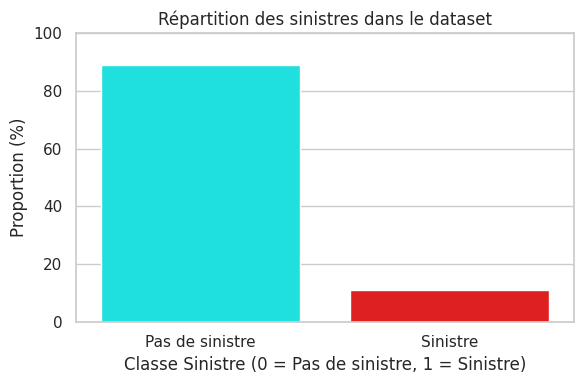

## Analyse de la variable numérique : Exposure



,Exposure
count,163212.000000
mean,0.889744
std,0.244202
min,0.002740
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


/tmp/ipykernel_38726/2819472562.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


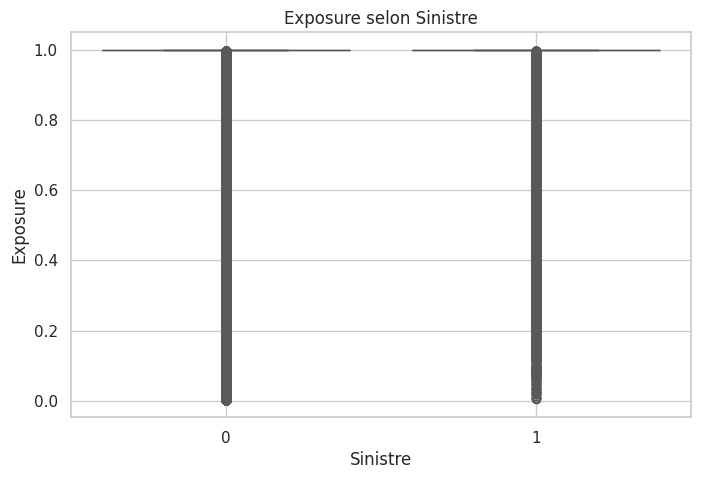

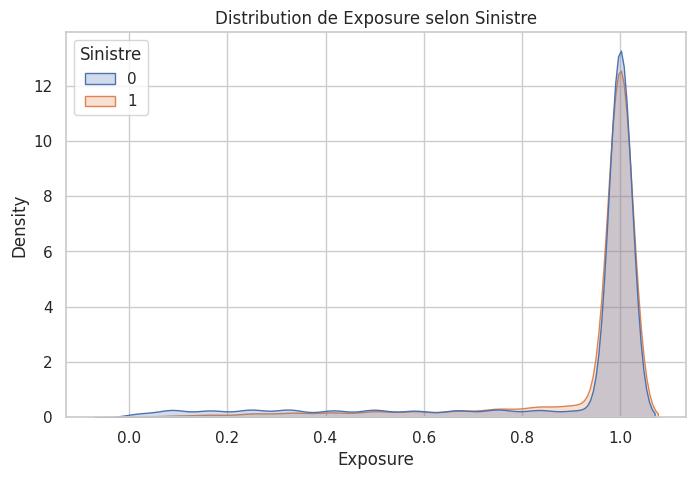


🧪 Test de Kolmogorov-Smirnov sur la variable 'Exposure'
------------------------------------------------------------
📈 Statistique KS : 0.0606
📊 Valeur p       : 3.5305e-52
✅ Résultat : Les distributions sont **significativement différentes** (p < 0.05)
📌 Intensité de l'écart : ⚪️ Très faible différence
------------------------------------------------------------
📉 Médiane (classe 0) : 1.00
📈 Médiane (classe 1) : 1.00
➡️  Différence absolue de médiane : 0.00

## Analyse de la variable numérique : Power



,Power
count,163212.000000
mean,0.197438
std,0.081652
min,0.000000
25%,0.141631
50%,0.184549
75%,0.240343
max,1.000000


/tmp/ipykernel_38726/2819472562.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


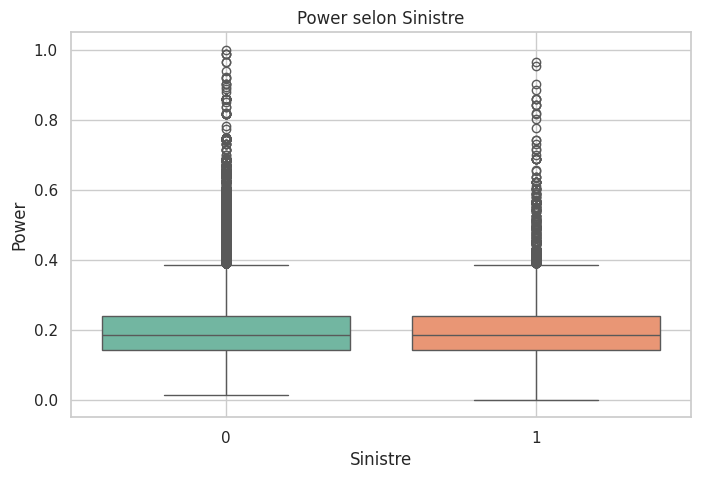

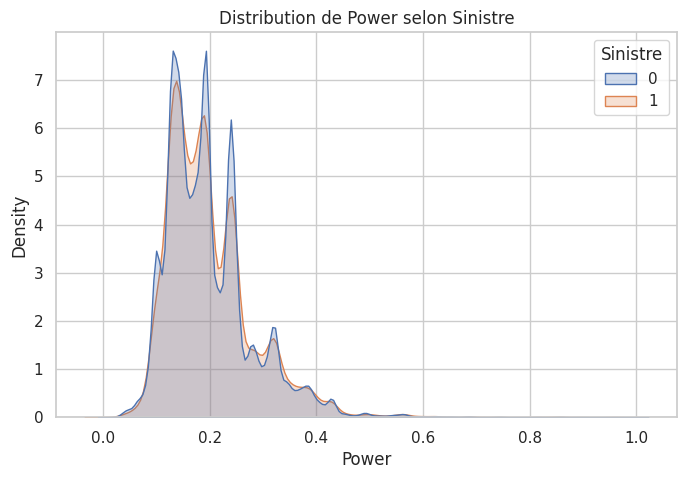


🧪 Test de Kolmogorov-Smirnov sur la variable 'Power'
------------------------------------------------------------
📈 Statistique KS : 0.0172
📊 Valeur p       : 1.2912e-04
✅ Résultat : Les distributions sont **significativement différentes** (p < 0.05)
📌 Intensité de l'écart : ⚪️ Très faible différence
------------------------------------------------------------
📉 Médiane (classe 0) : 0.18
📈 Médiane (classe 1) : 0.18
➡️  Différence absolue de médiane : 0.00

## Analyse de la variable numérique : DriverAge



,DriverAge
count,163212.000000
mean,0.376636
std,0.192618
min,0.000000
25%,0.220779
50%,0.363636
75%,0.519481
max,1.000000


/tmp/ipykernel_38726/2819472562.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


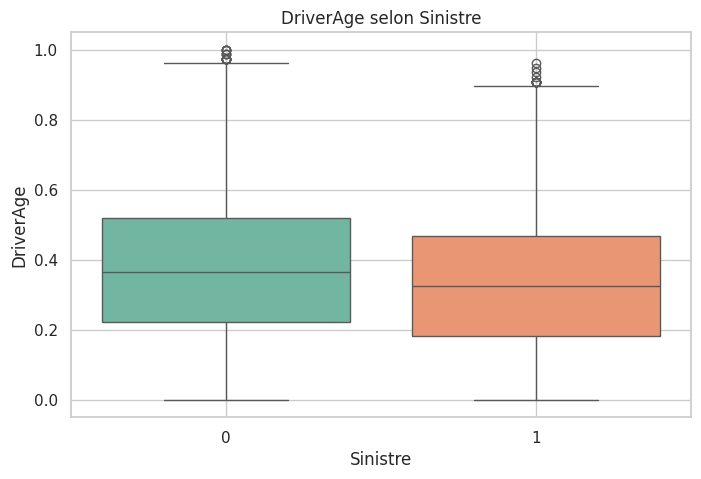

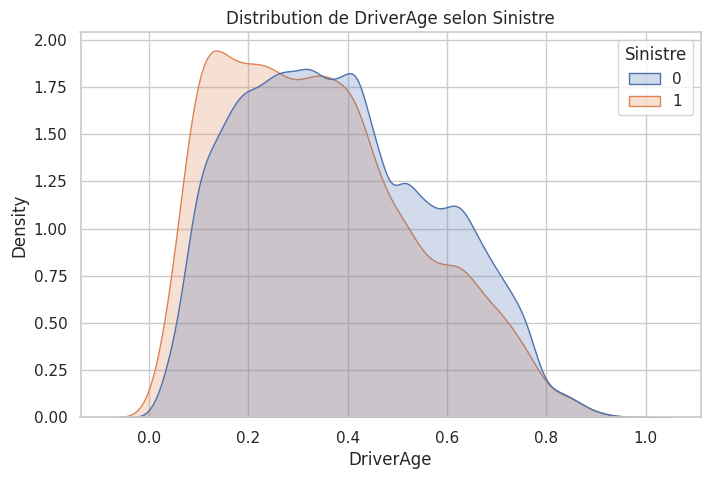


🧪 Test de Kolmogorov-Smirnov sur la variable 'DriverAge'
------------------------------------------------------------
📈 Statistique KS : 0.0841
📊 Valeur p       : 2.9891e-100
✅ Résultat : Les distributions sont **significativement différentes** (p < 0.05)
📌 Intensité de l'écart : ⚪️ Très faible différence
------------------------------------------------------------
📉 Médiane (classe 0) : 0.36
📈 Médiane (classe 1) : 0.32
➡️  Différence absolue de médiane : 0.04

## Analyse de la variable numérique : Density



,Density
count,163212.000000
mean,0.060615
std,0.137845
min,0.000000
25%,0.009328
50%,0.020428
75%,0.043230
max,1.000000


/tmp/ipykernel_38726/2819472562.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


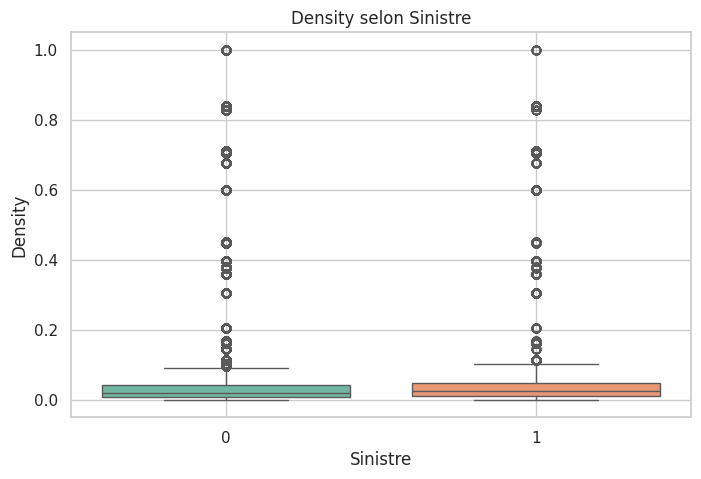

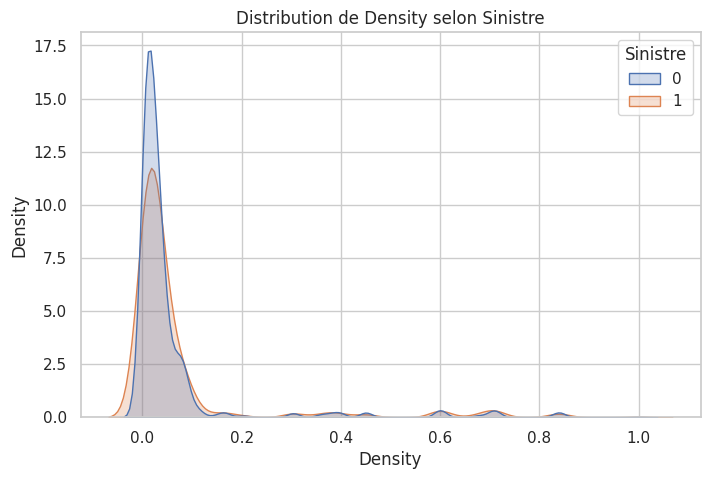


🧪 Test de Kolmogorov-Smirnov sur la variable 'Density'
------------------------------------------------------------
📈 Statistique KS : 0.0443
📊 Valeur p       : 3.8682e-28
✅ Résultat : Les distributions sont **significativement différentes** (p < 0.05)
📌 Intensité de l'écart : ⚪️ Très faible différence
------------------------------------------------------------
📉 Médiane (classe 0) : 0.02
📈 Médiane (classe 1) : 0.03
➡️  Différence absolue de médiane : 0.01

## Analyse de la variable catégorielle : Fuel_type



,Fuel_type,Effectif,Nombre_sinistres,Taux_de_sinistre
0,1,50394,6348,12.60%
1,0,112818,11928,10.57%


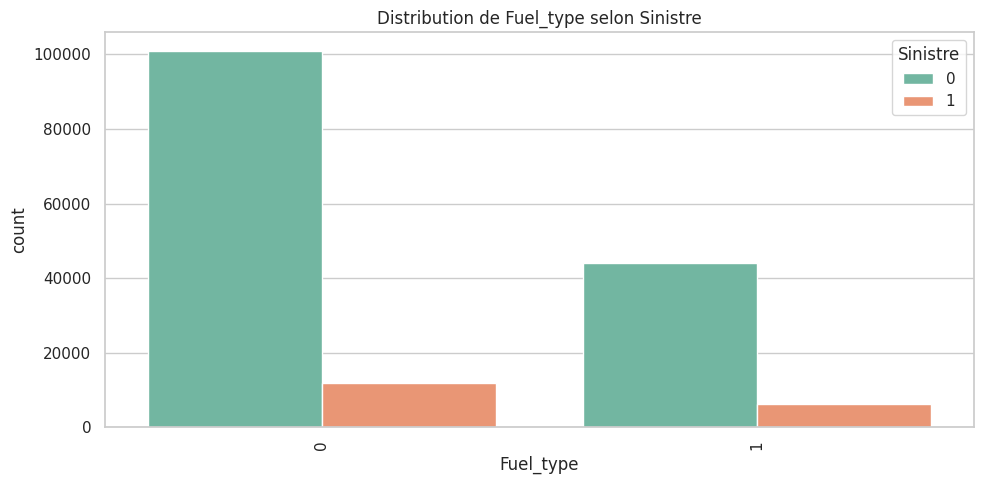

## Analyse de la variable catégorielle : Sex



,Sex,Effectif,Nombre_sinistres,Taux_de_sinistre
0,0,43168,5078,11.76%
1,1,120044,13198,10.99%


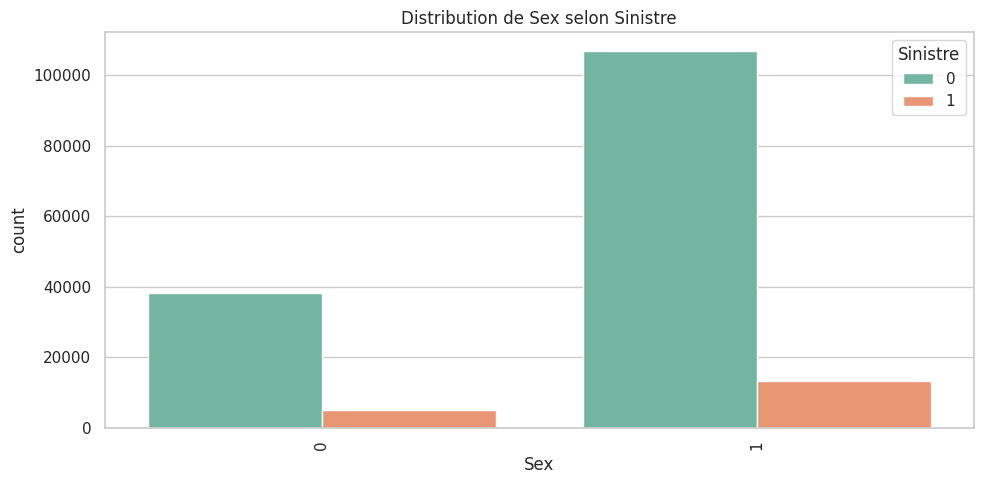

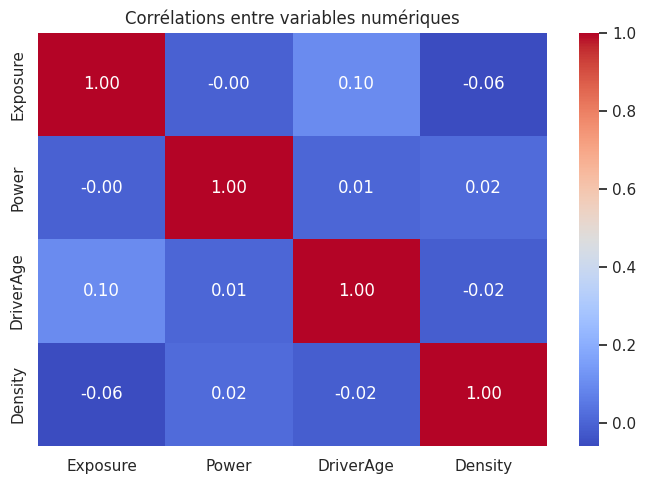

/tmp/ipykernel_38726/2745208832.py:50: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_pvalue, subset=['p-value']) \
/tmp/ipykernel_38726/2745208832.py:51: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'background-color: limegreen' if x else 'background-color: lightcoral',
/tmp/ipykernel_38726/2745208832.py:53: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_strength, subset=['Force de la corrélation']) \


,Paire de variables,Cramer's V,Force de la corrélation,p-value,Significatif
0,Fuel_type - Sinistre,0.030,Faible,0.0000,True
1,Fuel_type - Sex,0.103,Modérée,0.0000,True
2,Sinistre - Sex,0.011,Faible,0.0000,True


In [20]:
# Liste des variables
vars_num = ['Exposure', 'Power', 'DriverAge', 'Density']
vars_cat = ['Fuel_type', 'Sex']


afficher_repartition_sinistres(df_beMTPL,'belge')
# Analyse automatique
for var in vars_num:
    analyse_variable_numerique(df_beMTPL, var,'belge')

for var in vars_cat:
    analyse_variable_categorielle(df_beMTPL, var,'belge')

#Corrélation 
afficher_correlation(df_beMTPL, vars_num,'belge')
results = analyze_categorical_correlation(df_beMTPL)

# ALL

In [21]:
def plot_kde_by_country(df, country_col='Country', var = 'Sinistre'):
    # Variables à exclure car ce sont des catégorielles même si elles sont numériques
    categorical_numerics = ['Sinistre', 'Sex', 'Fuel_type']

    # Sélection des variables numériques sans les variables catégorielles ni le pays
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in categorical_numerics + [country_col]]

    # Boucle sur chaque variable numérique "continue"
    for col in numeric_cols:
        plt.figure(figsize=(10, 6))
        sns.kdeplot(data=df, x=col, hue=country_col, fill=True, common_norm=False, alpha=0.5)
        plt.title(f'Distribution de {col} par pays')
        plt.xlabel(col)
        plt.ylabel('Densité')
        plt.tight_layout()
        plt.savefig(f"images/kde_all_{col}_{var}_.png")
        plt.show()


def plot_boxplots_by_country(df, country_col='Country', var = 'Sinistre'):
    # Variables à exclure car ce sont des catégorielles même si elles sont numériques
    categorical_numerics = ['Sinistre', 'Sex', 'Fuel_type']

    # Sélection des variables numériques sans les variables catégorielles ni le pays
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in categorical_numerics + [country_col]]

    # Boucle sur chaque variable numérique
    for col in numeric_cols:
        plt.figure(figsize=(10, 6))
        sns.boxplot(
            data=df,
            x=country_col,
            y=col,
            palette='pastel',
            showfliers=False  # Cache les outliers pour rendre plus lisible (optionnel)
        )  # Couleurs différentes
        plt.title(f'Repartition de {col} par pays')
        plt.xlabel('Pays')
        plt.ylabel(col)
        plt.tight_layout()
        plt.savefig(f"images/boxplot_all_{col}_{var}_.png")
        plt.show()


def plot_multiple_proportions(data, group_col, target_cols, palette='Set2', var = 'Sinistre'):
    for target_col in target_cols:
        # Comptage brut
        count_df = data.groupby([group_col, target_col]).size().reset_index(name='Count')
        
        # Total des lignes par group_col (ex: par pays)
        total_df = data.groupby(group_col).size().reset_index(name='Total')
        
        # Fusion des deux tableaux
        merged_df = pd.merge(count_df, total_df, on=group_col)
        merged_df['Proportion'] = merged_df['Count'] / merged_df['Total']
        
        # Affichage
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(data=merged_df, x=group_col, y='Proportion', hue=target_col, palette=palette)

        # Ajout des étiquettes
        for container in ax.containers:
            ax.bar_label(container, labels=[f'{100 * h:.2f}%' for h in container.datavalues], label_type='edge')

        plt.ylim(0, 1)
        plt.title(f"Distribution de {target_col} par {group_col}", fontsize=16, weight='bold')
        plt.ylabel("Proportion (%)")
        plt.xlabel(group_col)
        plt.legend(title=target_col, loc='best')
        plt.tight_layout()
        plt.savefig(f"images/proportion_all_{target_col}_{var}_.png")
        plt.show()

# Liste des variables catégorielles à analyser
cat_vars = ['Sinistre', 'Sex', 'Fuel_type']

# Appel de la fonction


In [22]:
data_sin = data[data['Sinistre'] == 1]

In [23]:
data_nsin = data[data['Sinistre'] == 0]

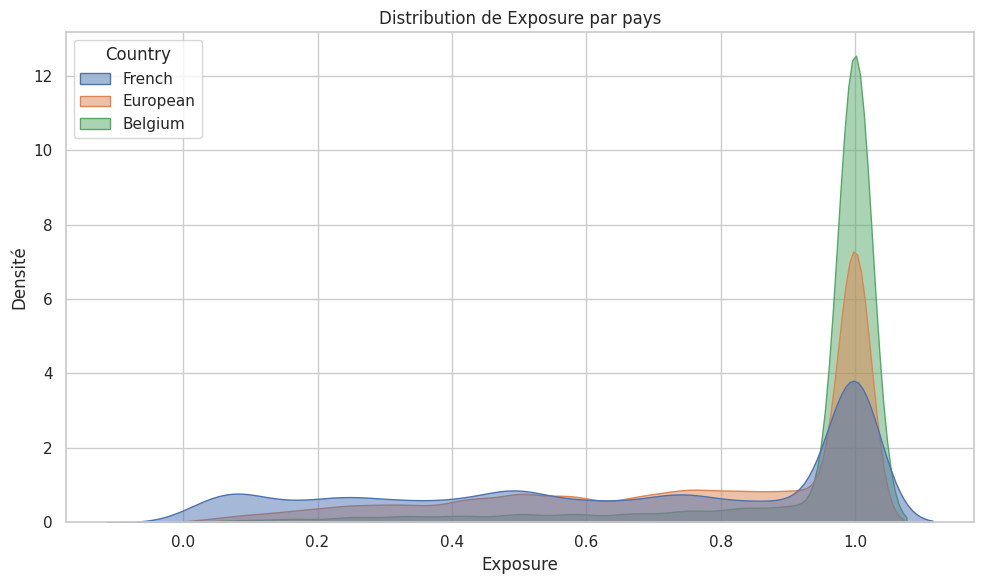

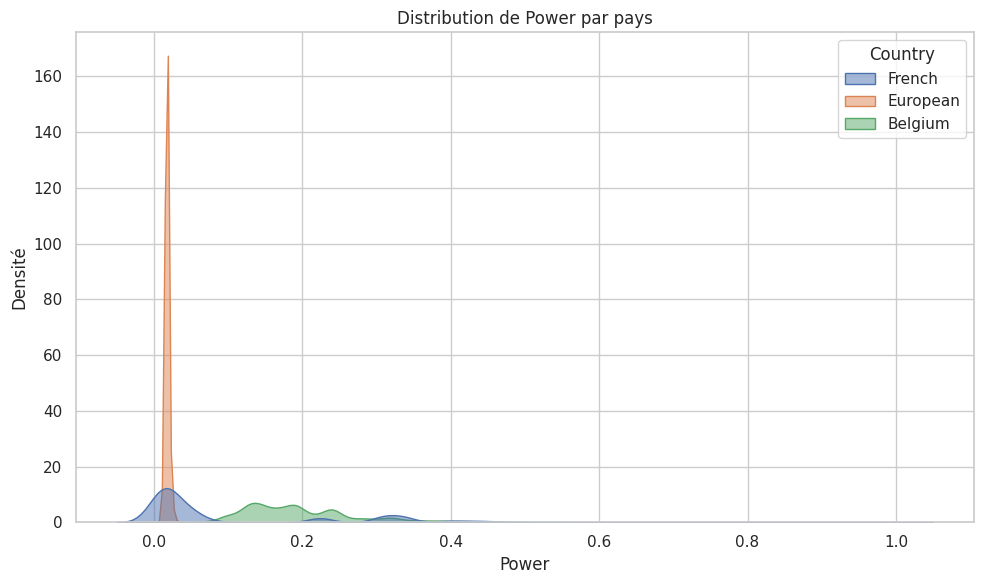

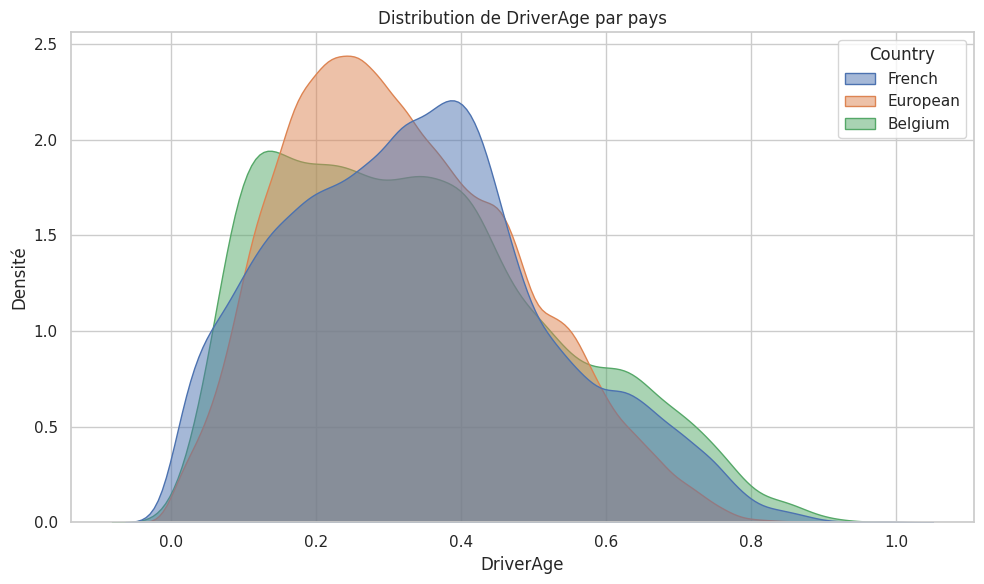

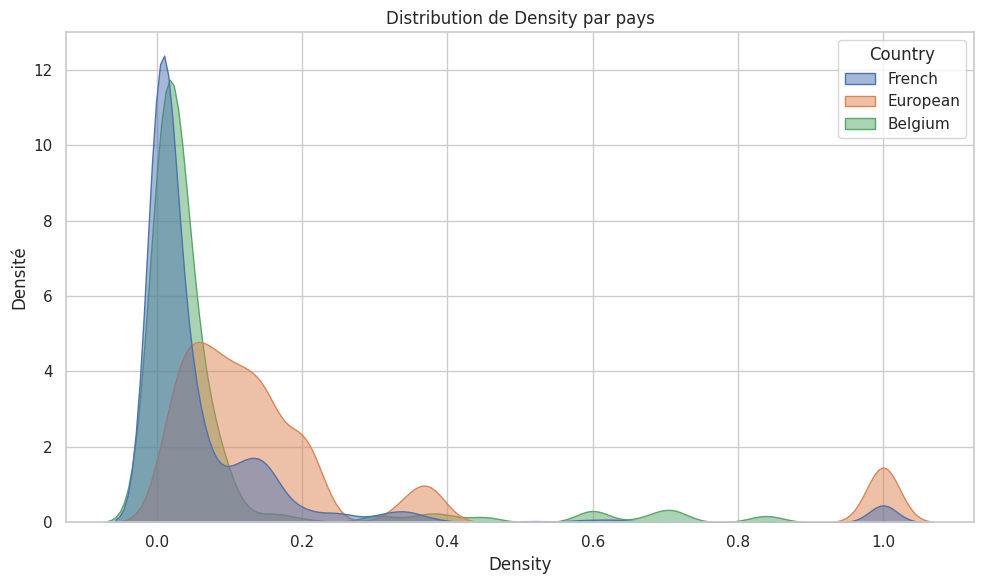

In [24]:
plot_kde_by_country(data_sin)

/tmp/ipykernel_38726/823348990.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


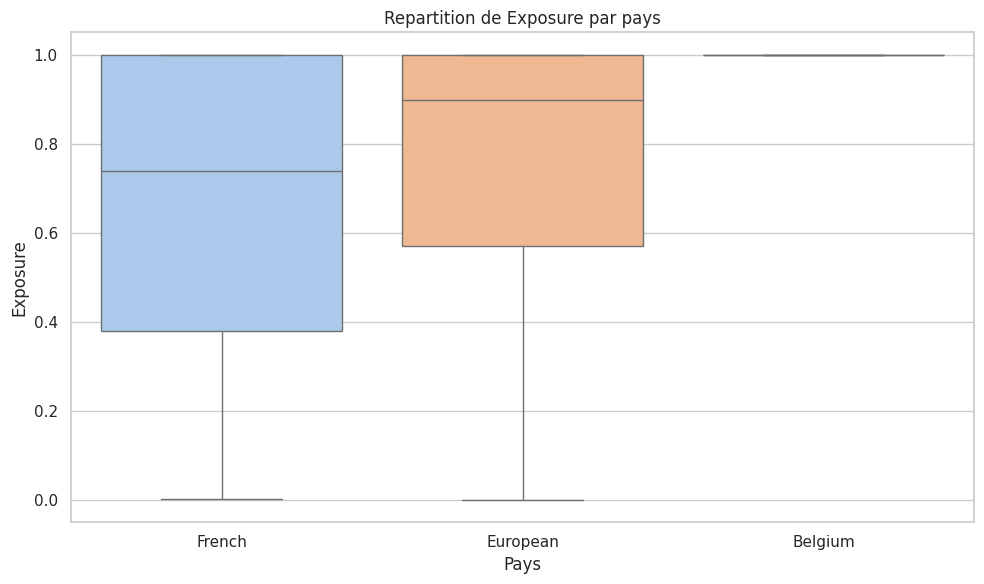

/tmp/ipykernel_38726/823348990.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


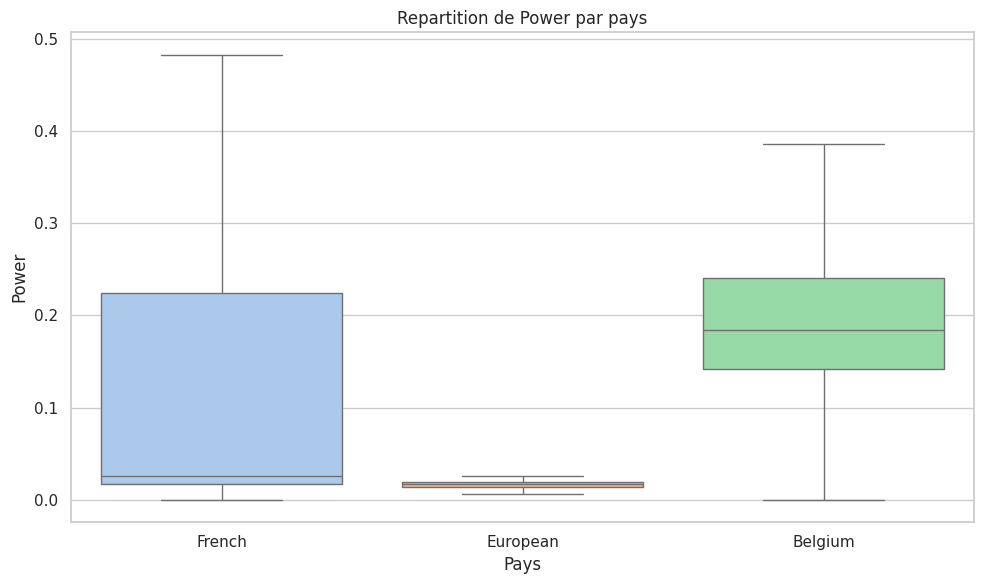

/tmp/ipykernel_38726/823348990.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


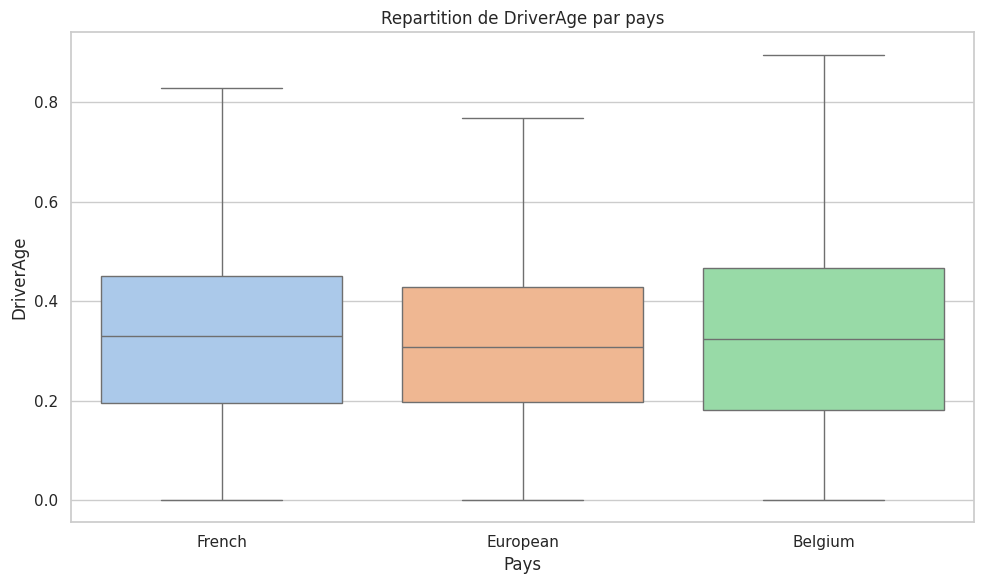

/tmp/ipykernel_38726/823348990.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


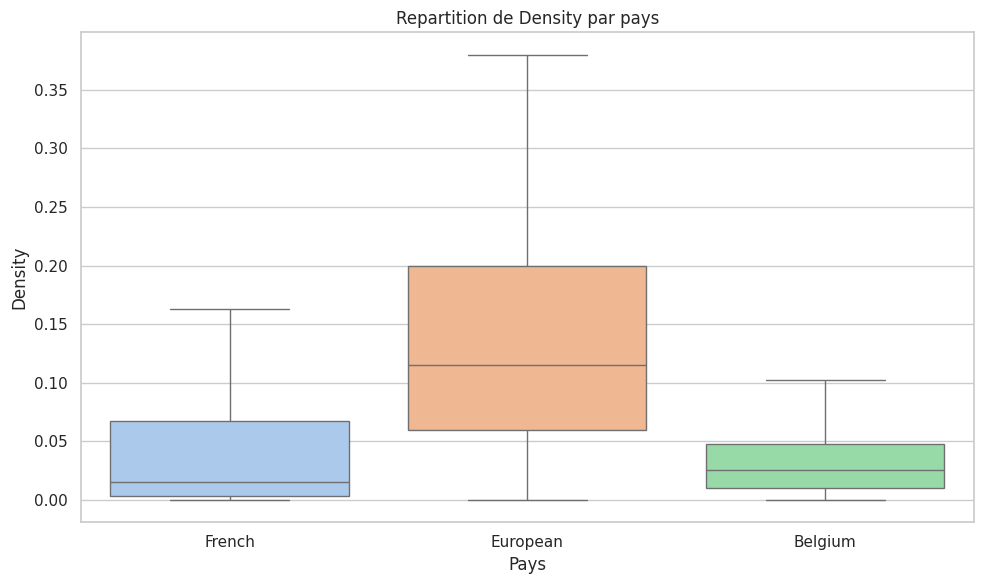

In [25]:
plot_boxplots_by_country(data_sin)

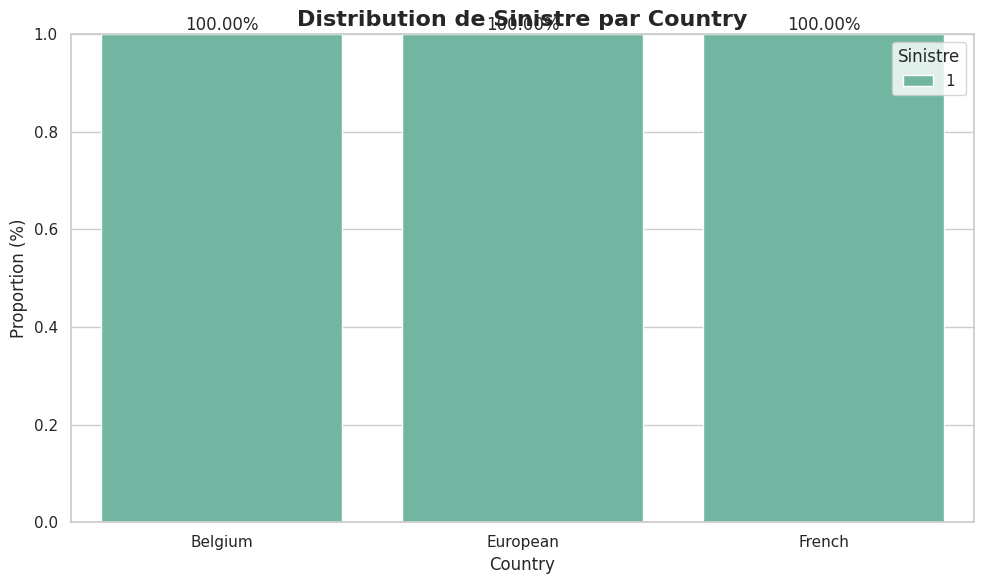

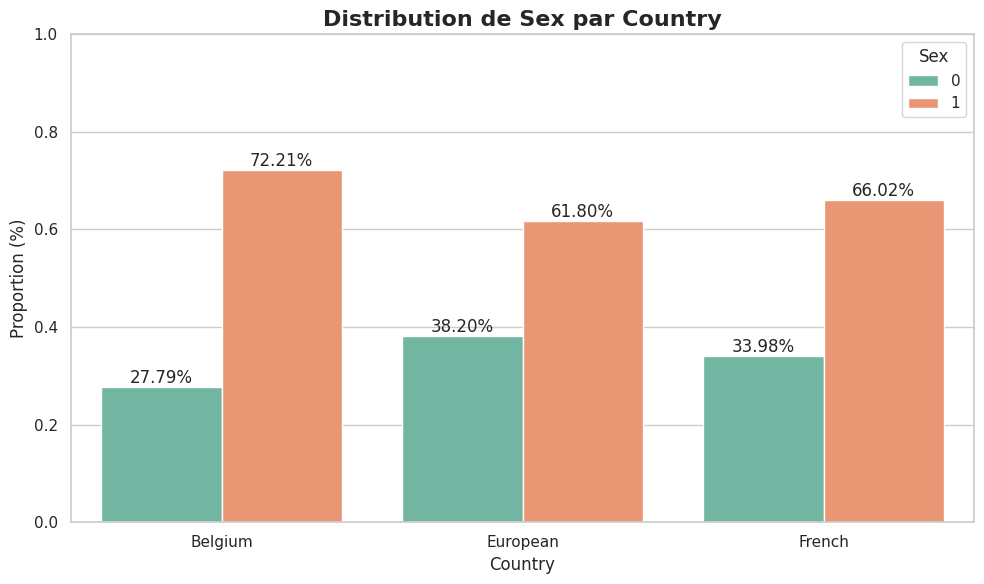

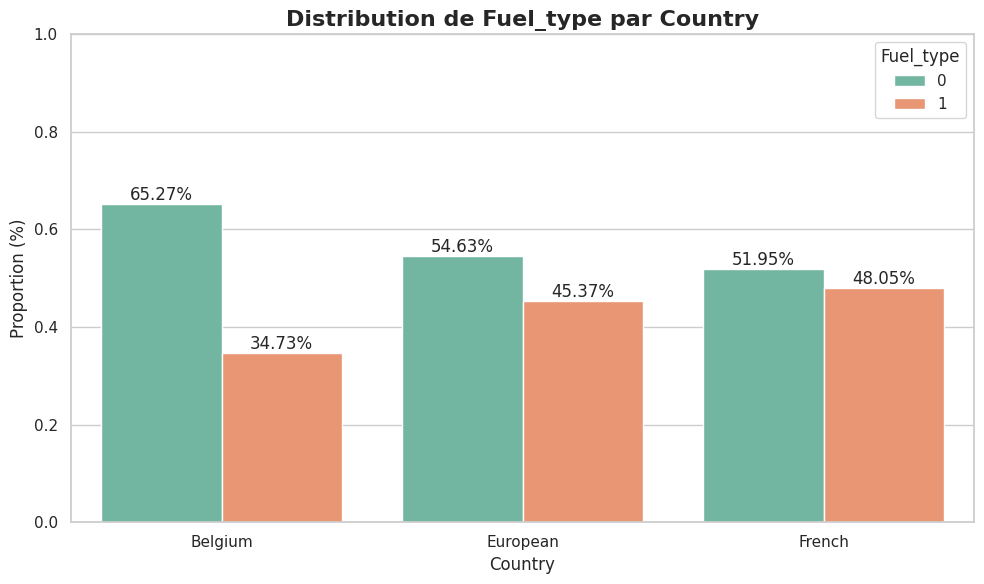

In [26]:
plot_multiple_proportions(data_sin, group_col='Country', target_cols=cat_vars)

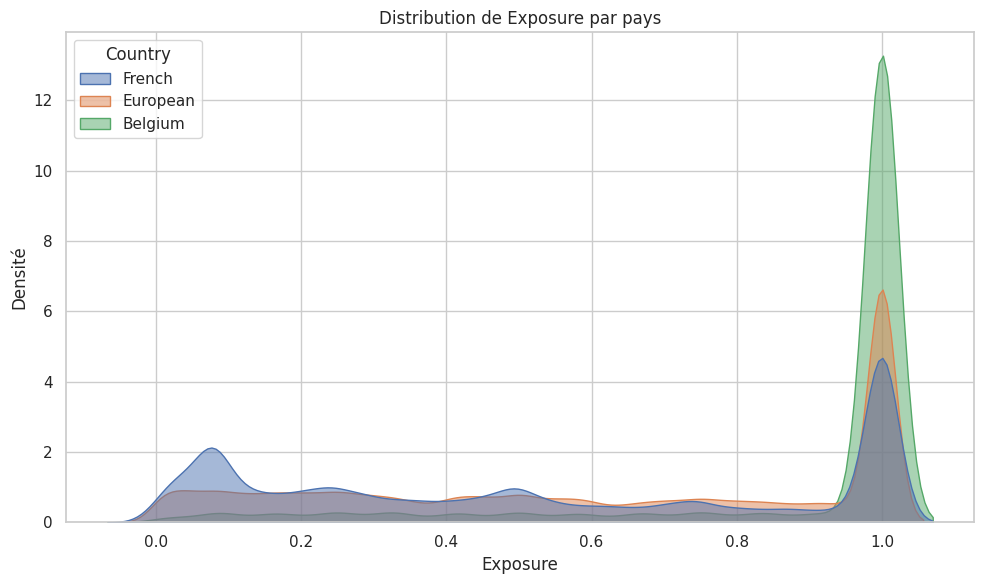

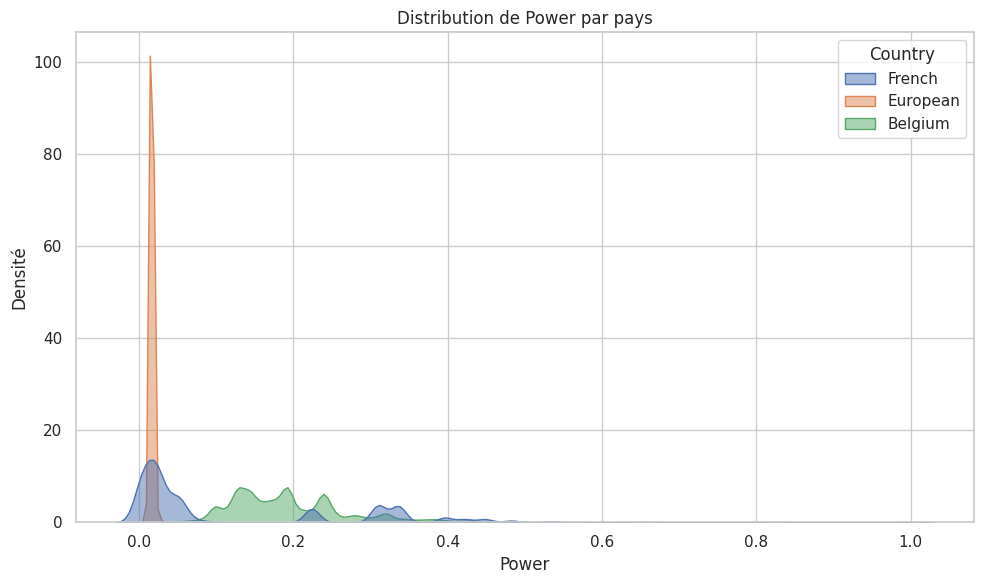

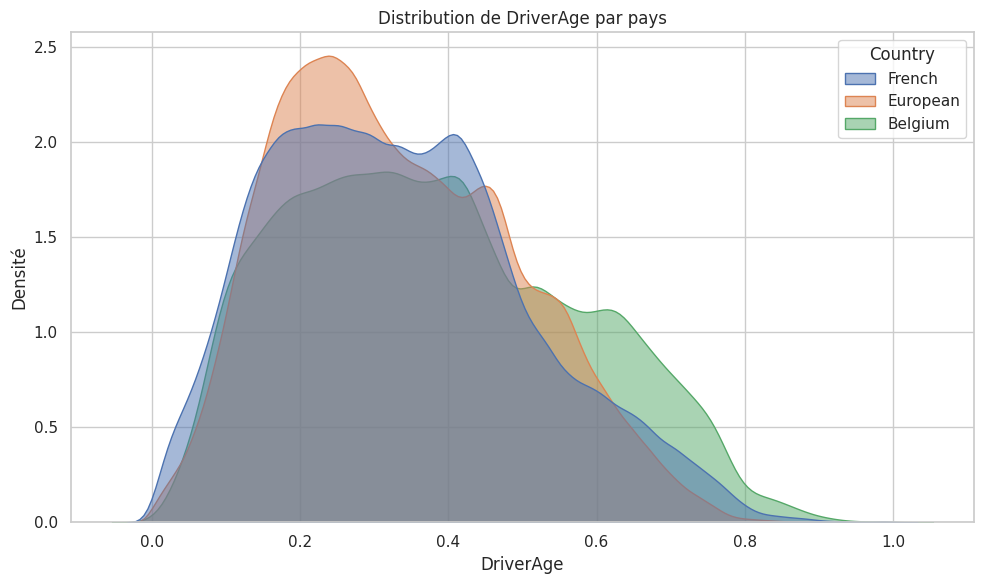

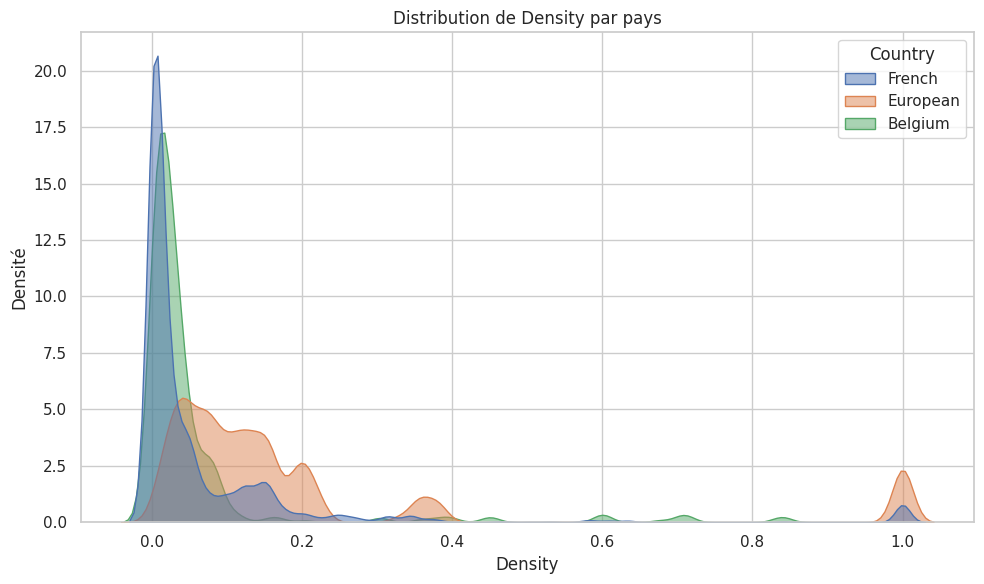

In [27]:
plot_kde_by_country(data_nsin, var='Non_Sinistre')

/tmp/ipykernel_38726/823348990.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


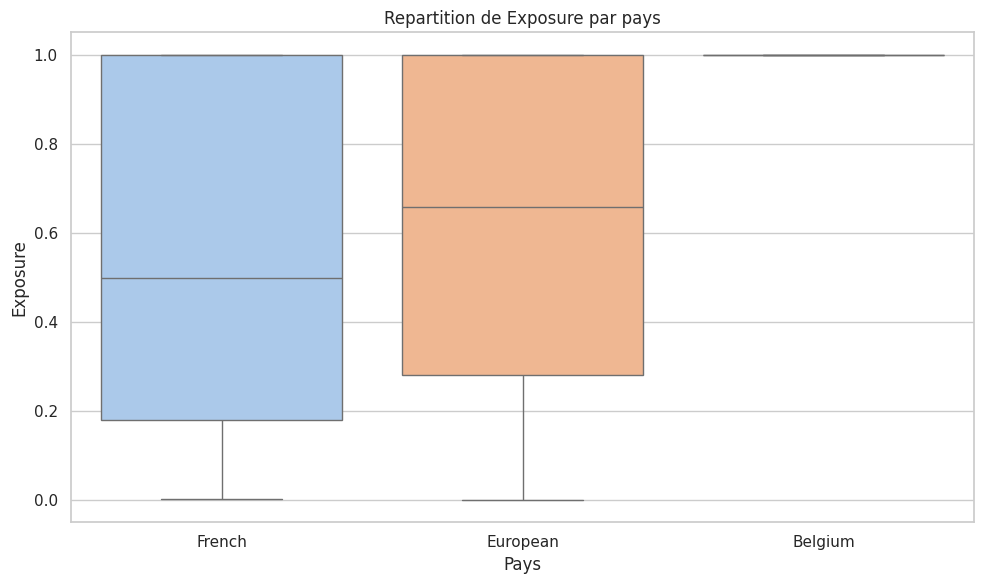

/tmp/ipykernel_38726/823348990.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


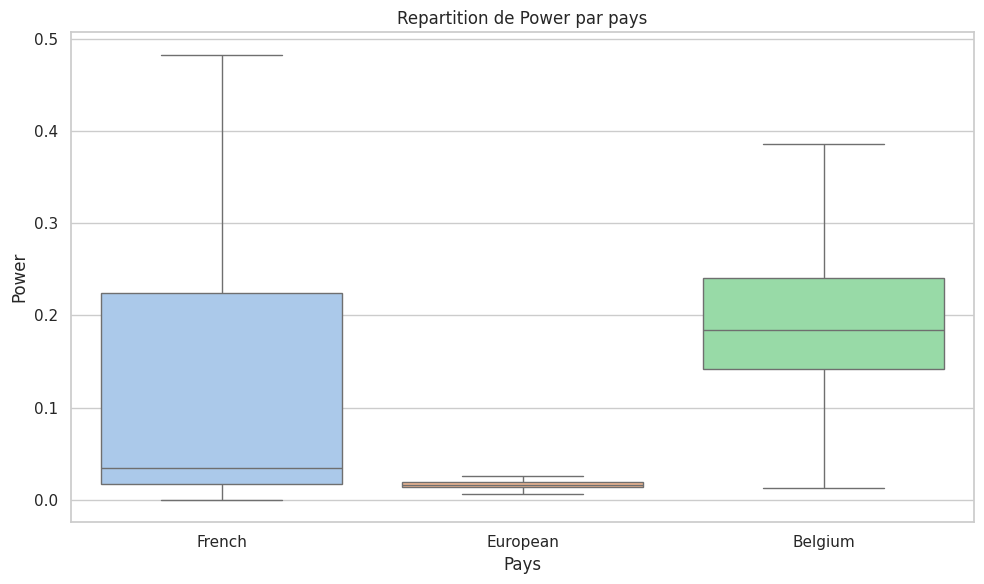

/tmp/ipykernel_38726/823348990.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


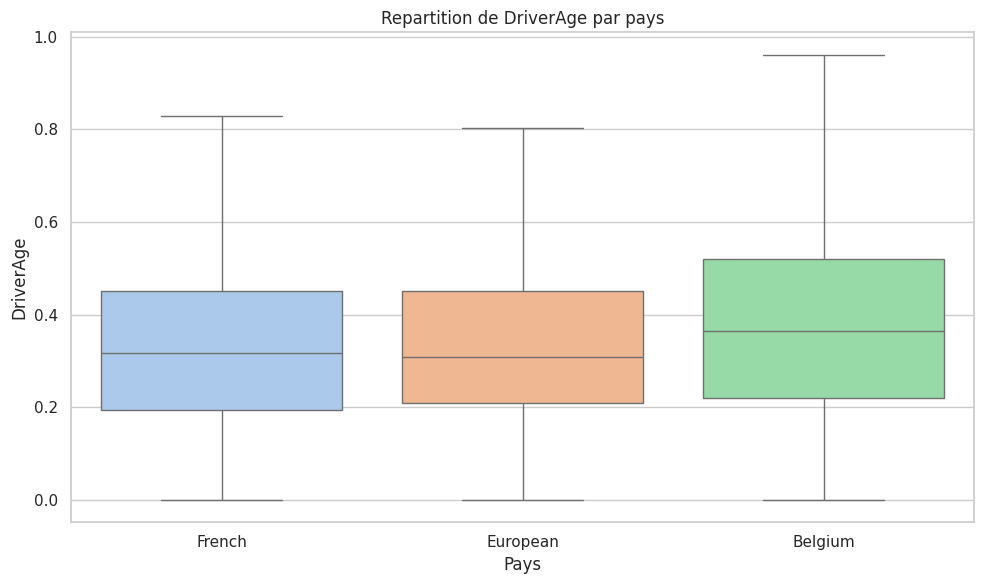

/tmp/ipykernel_38726/823348990.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


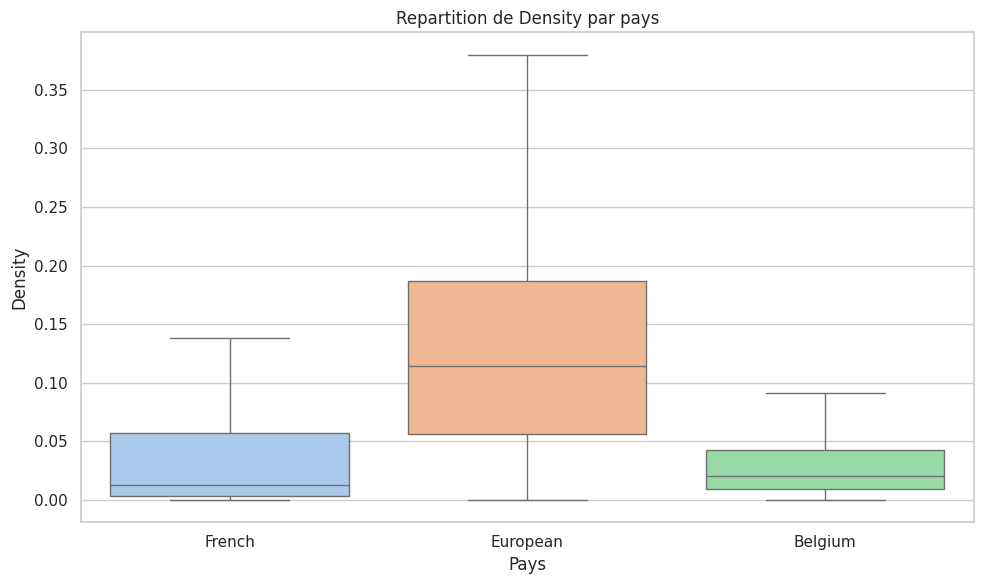

In [28]:
plot_boxplots_by_country(data_nsin, var='Non_Sinistre')

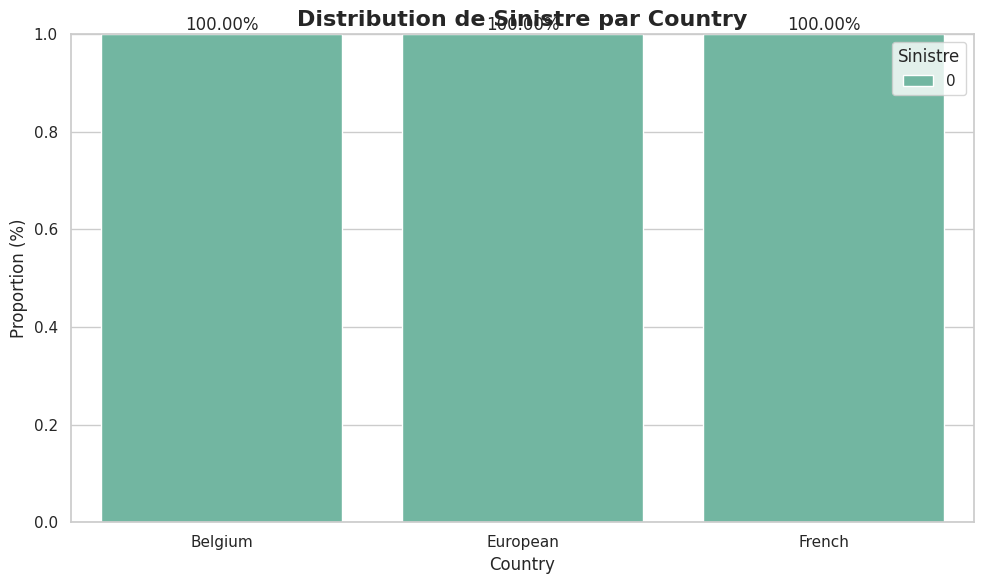

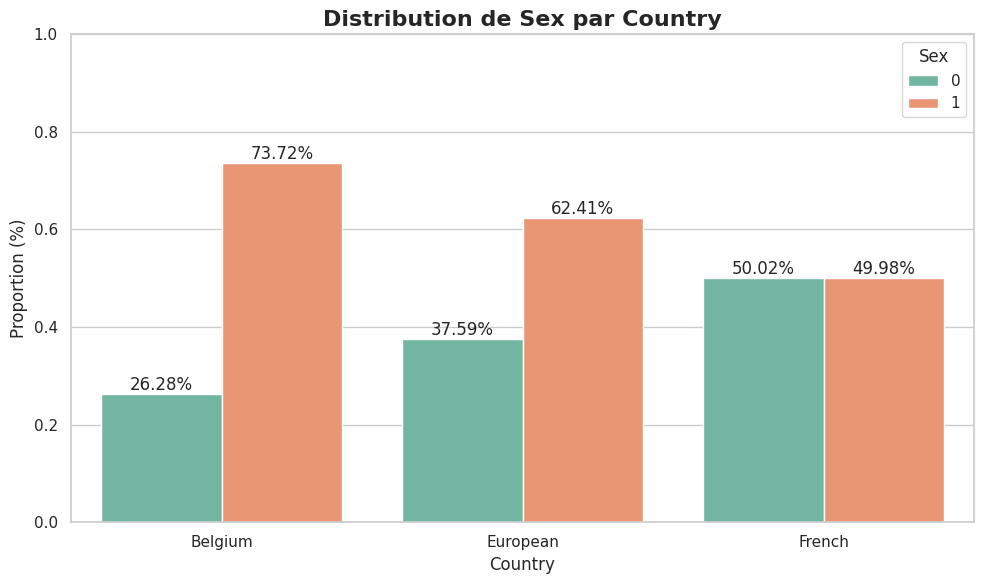

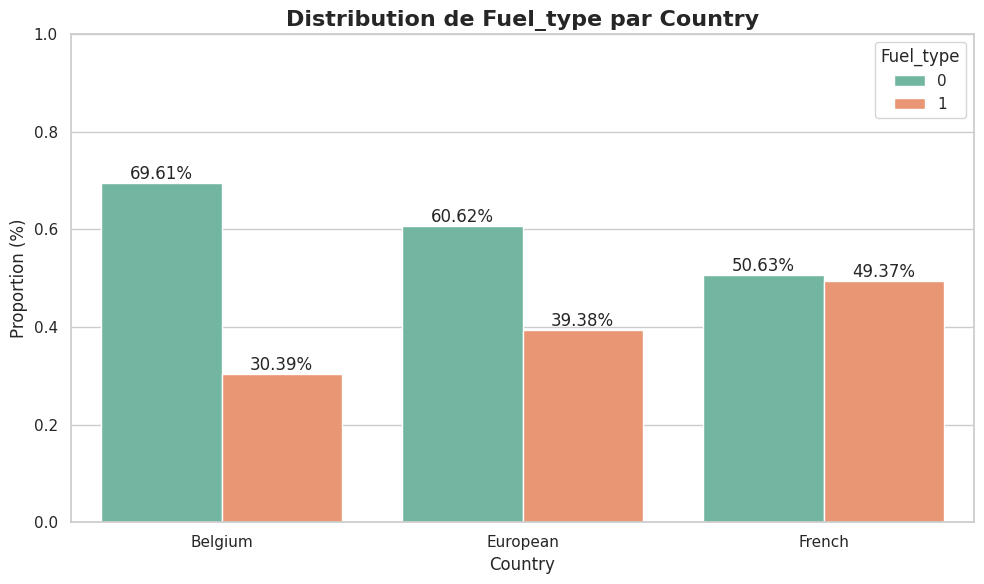

In [29]:
plot_multiple_proportions(data_nsin, var='Non_Sinistre', group_col='Country', target_cols=cat_vars)